# Identify MHWs (marine heat waves) in an Australian Marine Park

* **Compatibility:** Notebook currently compatible with the `NCI` environment
* **Products used:** `modis_oc_1d development` database
* **Requirements:** You need to run the following commands from the command line prior to launching jupyter notebook from the same terminal so that the required libraries and paths are set: 
```
module use /g/data/v10/public/modules/modulefiles;
module load dea
```    
* **Prerequisites:** The [introduction_to_MODIS_oceancolor](./introduction_to_modis_oceancolour.ipynb) notebook

## Background

The Australian Government has established 60 marine parks around the country. Marine parks help conserve marine habitats and the marine species that live within and rely on these habitats. Marine parks also provide places for people to watch wildlife, dive, and go boating, snorkelling and fishing. Importantly, they create jobs in industries like fishing and tourism, and provide us with food and energy.

Understanding and monitoring the environmental characteristics of Australian marine parks can be challenging due to their remoteness and large sizes. Marine surveys and in-situ observation instruments can provide some environmental information, however these are often very expensive and lack spatial and/or temporal coverage.

### Digitial Earth Australia use case

Imagery from satellites such as [NASA's MODIS](https://terra.nasa.gov/about/terra-instruments/modis) and [NOAA's AVHRR](https://www.ospo.noaa.gov/Operations/POES/NOAA15/avhrr.html) is available for free for the entire planet, making satellite imagery a powerful and cost-effective tool for monitoring Australian marine parks. 

Satellite data can provide envrionmental information on water quality, sea surface temperature and primary productivity of Australian marine parks in a timely manner. Satellite data can also help detect and monitor harmful events such as algae blooms and marine heat waves occuring in Australian marine parks.

## Description

In this worked example, we use [IMOS](http://imos.org.au/) MODIS SST (Sea Surface Temperature) data between 2002 and 2019 to identify the marine heat waves (MHWs) in an Australian marine park. MHWs can have signficiant ecological and economic impacts. We use the definition of [Hobday et al. (2016)](#References) to define a MHW event. A MHW is defined as a prolonged discrete anomalously warm water event that:
1. lasts for five or more days,
2. with SST warmer than the 90th percentile of baseline climatology, and
3. with well-defined start and end times.

Based on the SST anomaly between the maximum intensity and the mean of baseline climatology, we have also classified a MHW event into one of four categories using the definition of [Hobday et al. (2018)](#References):
1. Moderate: 1-2 times of the intensity threshold,
2. Strong: 2-3 times of the intensity threshold,
3. Severe: 3-4 times of the intensity threshold, and
4. Extreme: >4 times of the intensity threshold.

The worked example demonstrates how to:

1. Load in MODIS SST data
2. If there are island(s)/reef(s) within the marine park, create buffer(s) around them to mask out the shallow water
3. Conduct zonal statistics to obtain an overall SST daily time series
4. Identify overall MHWs of the marine park
5. Identify per-pixel MHWs of the marine park 
6. Calculate summary MHWs statistics
7. Plot figures showing MHWs mapping results

## Getting started

To run this analysis, run all the cells in the notebook, starting with the [Load packages](#LoadPackages) cell.
    
After finishing the analysis, return to the [Analysis parameters](#AnalysisParameters) cell, modify some values (e.g. choose a different output crs or resolution or a different marine park) and re-run the analysis.

<a id='LoadPackages'></a>
## Load packages
Load key Python packages and supporting functions for the analysis.

In [1]:
%matplotlib inline


import matplotlib
import datacube
import fiona
import geopandas as gpd
import pandas as pd
import rasterio.features
import numpy as np
import shapefile as shpf
import scipy.ndimage as ndimage
import seaborn as sns
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import xarray as xr
import shapely
import os
import sys

from datacube import Datacube
from datacube.storage.masking import mask_invalid_data
from datacube.utils import geometry
from shapely.geometry import shape, mapping
from affine import Affine
from datetime import datetime
from osgeo import ogr
from scipy.ndimage import label
from matplotlib import gridspec

### The pad function (written by Eric Oliver) for linear interpolation of missing data in a time series

This function allows the user to specify the number of NaN observations over which to interpolate, and which to leave as NaNs. This is useful if you don't want to interpolate over a large number of consecutive missing values.

In [2]:
def pad(data, maxPadLength=False):
    '''
    Linearly interpolate over missing data (NaNs) in a time series.

    Inputs:

      data           Time series [1D numpy array]
      maxPadLength   Specifies the maximum length over which to interpolate,
                     i.e., any consecutive blocks of NaNs with length greater
                     than maxPadLength will be left as NaN. Set as an integer.
                     maxPadLength=False (default) interpolates over all NaNs.

    Written by Eric Oliver, Institue for Marine and Antarctic Studies, University of Tasmania, Jun 2015
    '''
    data_padded = data.copy()
    bad_indexes = np.isnan(data)
    good_indexes = np.logical_not(bad_indexes)
    good_data = data[good_indexes]
    interpolated = np.interp(bad_indexes.nonzero()[0], good_indexes.nonzero()[0], good_data)
    data_padded[bad_indexes] = interpolated
    if maxPadLength:
        blocks, n_blocks = ndimage.label(np.isnan(data))
        for bl in range(1, n_blocks+1):
            if (blocks==bl).sum() > maxPadLength:
                data_padded[blocks==bl] = np.nan

    return data_padded

### The geometry_to_shapefile function for writting  polygon geometry to a shapefile

This function is used to write a polygon geometry to a ESRI shapefile

In [3]:
def geometry_to_shapefile(shapefileName,geom):
    # geom: shapely.geometry.polygon.Polygon

    # Define a polygon feature geometry with one attribute
    schema = {
        'geometry': 'Polygon',
        'properties': {'id': 'int'},
    }

    # Write a new Shapefile
    with fiona.open(shapefileName, 'w', 'ESRI Shapefile', schema) as collection:
        ## If there are multiple geometries, put the "for" loop here
        collection.write({
            'geometry': mapping(geom),
            'properties': {'id': 1},
        })
    return

### Connect to the datacube
Activate the datacube database, which provides functionality for loading and displaying stored Earth observation data.

Note that `modis_oc_1d` is development product. It is on a different database server `agdcstaging-db.nci.org.au`, which means that your ~/.pgpass file will need to specify a password to connect to it as well.

In [4]:
config = {'db_hostname': 'agdcstaging-db.nci.org.au',
          'db_port': 6432,
          'db_database': 'dea_modis'}

dc = Datacube(config=config)

<a id='AnalysisParameters'></a>
### Analysis parameters
    
The following cell set important parameters for the analysis:
  
* `output_crs`: The original MODIS SST data are in WGS84 coordinate system ('EPSG:4326'). If you want to change coordinate system please specify this prameter (e.g., 'EPSG:3577').
* `resolution`: The desirable spatial resolution of the MODIS SST data (e.g., `(-1300,1300)`).
* `buffer_dist`: The distance (unit corresponds to the selected coordinate system) used to buffer the island/reefs to mask out the shallow water.
* `AMP_name`: The name of the selected Australian marine park; note that many AMPs are too large to run effectively and efficiently under the VDI environment
* `AMPs_path`: The polygon shapefile of all Australian marine parks
* `reefs_islands_path`: The polygon shapefile of all Australian islands/reefs
* `AMP_shp`: The temporary shapefile to store the selected marine park polygon
* `reefs_islands_shp`: The temporary shapefile to store the islands/reefs polygons within the selected marine park
* `buffer_shp`: The temporary shapefile to store the buffer polygon of the islands/reefs within the selected marine park

In [5]:
output_crs = 'EPSG:4326'
resolution = (-0.01,0.01)
buffer_dist = 0.01
AMP_name = 'Cartier Island'
AMPs_path = '../../shapefiles/CMR_2013_dissolved_wgs84.shp'
reefs_islands_path = '../../shapefiles/Australian_Reefs_Islands1_dissloved.shp'
AMP_shp = '../../shapefiles/marine_park.shp'
reefs_islands_shp = '../../shapefiles/reefs_islands.shp'
buffer_shp = '../../shapefiles/reefs_islands_buffer.shp'

## Prepare the polygon area for the analysis

We want to use a polygon to define our region of interest. This polygon is a modified version of the selected marine park (e.g., after masking out the shallow water areas). 

### Buffer the islands/reefs and erase the buffer from the marine park polygon

The erased polygon is used as the geometry to load the MODIS SST data

In [6]:
##open the polygon
driver = ogr.GetDriverByName("ESRI Shapefile")        
dataSource = driver.Open(AMPs_path, 0)
layer = dataSource.GetLayer()
spatialRef = layer.GetSpatialRef()
crs = geometry.CRS(spatialRef.ExportToWkt())

for feature in layer:
    name = feature.GetField("MPA_NAME")
    if name == AMP_name:
        print(name)
        geom = shapely.wkt.loads(feature.GetGeometryRef().ExportToWkt())        
        AMP_Geometry = geometry.Geometry(mapping(geom),crs=crs)

with fiona.open(reefs_islands_path) as shapes:
        crs = geometry.CRS(shapes.crs_wkt)
        first_geometry = next(iter(shapes))['geometry']
        reefs_islands_Geometry = geometry.Geometry(first_geometry, crs=crs)

AMP_polygon = shape(AMP_Geometry) # the marine park polygon
# delete the temporary shapefiles so that new shapefles can be written
if os.path.exists(AMP_shp):
     driver.DeleteDataSource(AMP_shp)
if os.path.exists(reefs_islands_shp):
    driver.DeleteDataSource(reefs_islands_shp)
if os.path.exists(buffer_shp):
    driver.DeleteDataSource(buffer_shp)
#write the marine park polygon to a shapefile    
geometry_to_shapefile(AMP_shp,AMP_polygon)

intersect_geom =  reefs_islands_Geometry.intersection(AMP_Geometry)
if intersect_geom.is_empty: # islands/reefs polygons do not intersect the marine park polyon
    newGeom1 = mapping(AMP_polygon)
else:
    reefs_islands_polygon = shape(intersect_geom) # islands/reefs within the marine park
    buffer_polygon = shape(reefs_islands_polygon.buffer(buffer_dist)) # buffer the islands/reefs with a distance of the buffer_dist parameter
    newGeom = AMP_polygon.difference(buffer_polygon) # erase the buffer from the marine park polygon
    newGeom1 = mapping(newGeom)      
    #write the islands/reefs polygon and the buffer polygon to shapefiles  
    geometry_to_shapefile(reefs_islands_shp,reefs_islands_polygon)
    geometry_to_shapefile(buffer_shp,buffer_polygon)
    
marine_geom = geometry.Geometry(newGeom1, crs=crs) # the marine_geom geometry is used to load the MODIS data


Cartier Island


## Build query and load data

We will calculate the time taken to load the data as well.

In [7]:
query = {'geopolygon': marine_geom,
         'output_crs': output_crs,
         'resolution': resolution
         }

Here we do not specify a time parameter, meaning that all available observations will be returned.

If you want to load data for a long time period, you need to keep the bounding box for the query very small. Conversely, if you load a large area, you need to keep the time period short. This is to limit the amount of data that is loaded into memory at any one time.

In [8]:
time1 = datetime.now()
MODIS_data = dc.load(product='modis_oc_1d', measurements=(['sst']), **query)
time2 = datetime.now()
diff = time2 - time1
print('took',diff, 'to finish')

took 0:13:18.630102 to finish


### Create a mask for the area covered by the erased marine park polygon

We only want to keep data within the `marine_geom`, so we create a mask and remove any data outside this region, and any no-data values from the MODIS data.

In [9]:
mask = rasterio.features.geometry_mask([marine_geom.to_crs(MODIS_data.geobox.crs) for geoms in [marine_geom]],
                                           out_shape=MODIS_data.geobox.shape,
                                           transform=MODIS_data.geobox.affine,
                                           all_touched=False,
                                           invert=True)
MODIS_data = MODIS_data.where(mask)
MODIS_data_cleaned = mask_invalid_data(MODIS_data)

### check the loaded MODIS SST data

note the time dimension

In [10]:
MODIS_data_cleaned

<xarray.Dataset>
Dimensions:    (latitude: 14, longitude: 15, time: 6214)
Coordinates:
  * time       (time) datetime64[ns] 2002-07-04T11:59:59.999999 ... 2019-07-22T11:59:59.999999
  * latitude   (latitude) float64 -12.47 -12.48 -12.49 ... -12.58 -12.59 -12.6
  * longitude  (longitude) float64 123.5 123.5 123.5 123.5 ... 123.6 123.6 123.6
Data variables:
    sst        (time, latitude, longitude) float32 nan nan nan ... nan nan nan
Attributes:
    crs:      EPSG:4326

### plot a daily SST image
A quick check of the loaded data

<Figure size 432x360 with 0 Axes>

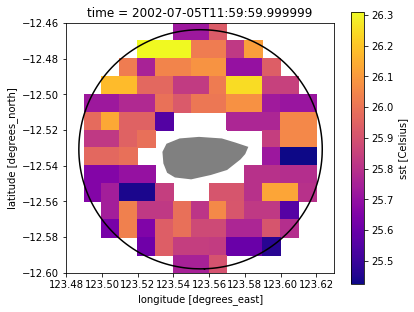

In [11]:
# calculate the aspect of the marine park extent, for the proper display of the SST image
h_w_ratio = round(MODIS_data_cleaned.latitude.size / MODIS_data_cleaned.longitude.size, 1)
width = 6
height = round(width * h_w_ratio)
plt.figure(figsize=(width,height))

if os.path.exists(reefs_islands_shp): 
    # plot the islands/reefs
    shape_plot = gpd.read_file(reefs_islands_shp)
    shape_plot.plot(figsize=(width,height),color='gray')

# plot the marine park outline
plt.plot(*AMP_polygon.exterior.xy, 'k');
# plot the SST image
MODIS_data_cleaned.sst[1].plot(cmap='plasma')

## Calculate some zonal statistics

We want to get a timeseries of SST for the marine park based on the mean/max/min/std of all pixels.

In [12]:
MODIS_data_cleaned['sst_mean'] = MODIS_data_cleaned.sst.mean(dim=['longitude','latitude'])
MODIS_data_cleaned['sst_min'] = MODIS_data_cleaned.sst.min(dim=['longitude','latitude'])
MODIS_data_cleaned['sst_max'] = MODIS_data_cleaned.sst.max(dim=['longitude','latitude'])
MODIS_data_cleaned['sst_std'] = MODIS_data_cleaned.sst.std(dim=['longitude','latitude'])

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [13]:
MODIS_data_cleaned

<xarray.Dataset>
Dimensions:    (latitude: 14, longitude: 15, time: 6214)
Coordinates:
  * time       (time) datetime64[ns] 2002-07-04T11:59:59.999999 ... 2019-07-22T11:59:59.999999
  * latitude   (latitude) float64 -12.47 -12.48 -12.49 ... -12.58 -12.59 -12.6
  * longitude  (longitude) float64 123.5 123.5 123.5 123.5 ... 123.6 123.6 123.6
Data variables:
    sst        (time, latitude, longitude) float32 nan nan nan ... nan nan nan
    sst_mean   (time) float32 26.897036 25.869576 26.680424 ... 26.299578 nan
    sst_min    (time) float32 26.605 25.425 26.38 nan ... 26.305 25.965 nan
    sst_max    (time) float32 27.24 26.31 27.03 nan ... 27.345 26.365 26.635 nan
    sst_std    (time) float32 0.14253645 0.18784189 0.1541689 ... 0.13139829 nan
Attributes:
    crs:      EPSG:4326

### Plot the mean SST over all available time

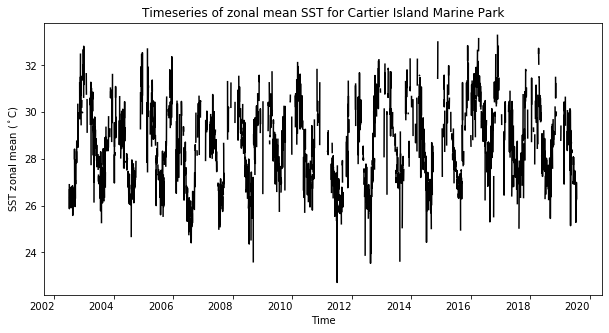

In [14]:
plt.figure(figsize=(10,5))
MODIS_data_cleaned.sst_mean.plot(color='k');
plt.xticks(rotation='horizontal');
plt.xlabel('Time');
plt.ylabel('SST zonal mean ($^\circ$C)');
plt.title('Timeseries of zonal mean SST for ' + AMP_name + ' Marine Park');

## Apply interpolation using the pad function to the daily mean, min, max and std SST time-series

In [15]:
MODIS_data_cleaned['sst_mean_interp'] = xr.DataArray(pad(MODIS_data_cleaned['sst_mean'].values,maxPadLength=False), 
                                                     dims='time', coords={'time': MODIS_data_cleaned['time']})
MODIS_data_cleaned['sst_min_interp'] = xr.DataArray(pad(MODIS_data_cleaned['sst_min'].values,maxPadLength=False), 
                                                    dims='time', coords={'time': MODIS_data_cleaned['time']})
MODIS_data_cleaned['sst_max_interp'] = xr.DataArray(pad(MODIS_data_cleaned['sst_max'].values,maxPadLength=False), 
                                                    dims='time', coords={'time': MODIS_data_cleaned['time']})
MODIS_data_cleaned['sst_std_interp'] = xr.DataArray(pad(MODIS_data_cleaned['sst_std'].values,maxPadLength=False), 
                                                    dims='time', coords={'time': MODIS_data_cleaned['time']})

In [16]:
MODIS_data_cleaned

<xarray.Dataset>
Dimensions:          (latitude: 14, longitude: 15, time: 6214)
Coordinates:
  * time             (time) datetime64[ns] 2002-07-04T11:59:59.999999 ... 2019-07-22T11:59:59.999999
  * latitude         (latitude) float64 -12.47 -12.48 -12.49 ... -12.59 -12.6
  * longitude        (longitude) float64 123.5 123.5 123.5 ... 123.6 123.6 123.6
Data variables:
    sst              (time, latitude, longitude) float32 nan nan nan ... nan nan
    sst_mean         (time) float32 26.897036 25.869576 ... 26.299578 nan
    sst_min          (time) float32 26.605 25.425 26.38 ... 26.305 25.965 nan
    sst_max          (time) float32 27.24 26.31 27.03 nan ... 26.365 26.635 nan
    sst_std          (time) float32 0.14253645 0.18784189 ... 0.13139829 nan
    sst_mean_interp  (time) float32 26.897036 25.869576 ... 26.299578 26.299578
    sst_min_interp   (time) float32 26.605 25.425 26.38 ... 26.305 25.965 25.965
    sst_max_interp   (time) float32 27.24 26.31 27.03 ... 26.365 26.635 26.635
    sst_std_interp   (time) float32 0.14253645 0.18784189 ... 0.13139829
Attributes:
    crs:      EPSG:4326

### Plot the interploated daily SST mean, minimum and maximum time-series

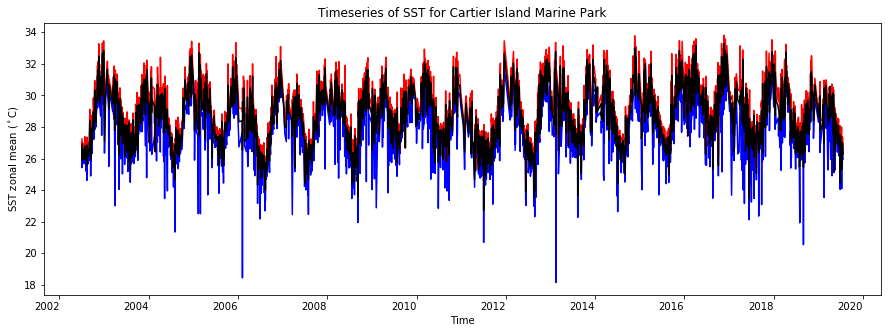

In [17]:
ax=plt.figure(figsize=(15,5))
MODIS_data_cleaned.sst_min_interp.plot(color='b');
MODIS_data_cleaned.sst_max_interp.plot(color='r');
MODIS_data_cleaned.sst_mean_interp.plot(color='k');
plt.xticks(rotation='horizontal');
plt.xlabel('Time');
plt.ylabel('SST zonal mean ($^\circ$C)');
plt.title('Timeseries of SST for ' + AMP_name + ' Marine Park');

## Identify overall MHWs of the marine park

from the overall daily SST time-series

#### The four Feb 29 dates from the leap years are drop to facilitate the MHW analysis

In [18]:
MODIS_data_cleaned=MODIS_data_cleaned.drop_sel(time=MODIS_data_cleaned.sel(time=slice('2004-02-29','2004-02-29')).time)
MODIS_data_cleaned=MODIS_data_cleaned.drop_sel(time=MODIS_data_cleaned.sel(time=slice('2008-02-29','2008-02-29')).time)
MODIS_data_cleaned=MODIS_data_cleaned.drop_sel(time=MODIS_data_cleaned.sel(time=slice('2012-02-29','2012-02-29')).time)
MODIS_data_cleaned=MODIS_data_cleaned.drop_sel(time=MODIS_data_cleaned.sel(time=slice('2016-02-29','2016-02-29')).time)

#### calculate the updated dayofyear for each date
After dropping the four Feb-29 days, we neeed to calculate the new dayofyears so that they are matched for all years

In [19]:
years = np.unique(MODIS_data_cleaned['time.year'].values)
doyList = []
for year in years:
    x = MODIS_data_cleaned.sel(time=slice(str(year),str(year)))
    x_doy = x['time.dayofyear']
    if str(year) in ['2004','2008','2012','2016']: 
        x_doy1 = x_doy[x_doy<=60]
        x_doy2 = x_doy[x_doy>60]-1
        x_doy=np.concatenate((x_doy1.values,x_doy2.values),axis=0)
    doyList.append(x_doy)

doyValues = np.concatenate(doyList,axis=0)
# add the doy values as a new variable
MODIS_data_cleaned['doy'] = xr.DataArray(doyValues,dims='time', coords={'time': MODIS_data_cleaned['time']})

In [20]:
MODIS_data_cleaned

<xarray.Dataset>
Dimensions:          (latitude: 14, longitude: 15, time: 6210)
Coordinates:
  * time             (time) datetime64[ns] 2002-07-04T11:59:59.999999 ... 2019-07-22T11:59:59.999999
  * latitude         (latitude) float64 -12.47 -12.48 -12.49 ... -12.59 -12.6
  * longitude        (longitude) float64 123.5 123.5 123.5 ... 123.6 123.6 123.6
Data variables:
    sst              (time, latitude, longitude) float32 nan nan nan ... nan nan
    sst_mean         (time) float32 26.897036 25.869576 ... 26.299578 nan
    sst_min          (time) float32 26.605 25.425 26.38 ... 26.305 25.965 nan
    sst_max          (time) float32 27.24 26.31 27.03 nan ... 26.365 26.635 nan
    sst_std          (time) float32 0.14253645 0.18784189 ... 0.13139829 nan
    sst_mean_interp  (time) float32 26.897036 25.869576 ... 26.299578 26.299578
    sst_min_interp   (time) float32 26.605 25.425 26.38 ... 26.305 25.965 25.965
    sst_max_interp   (time) float32 27.24 26.31 27.03 ... 26.365 26.635 26.635
    sst_std_interp   (time) float32 0.14253645 0.18784189 ... 0.13139829
    doy              (time) int64 185 186 187 188 189 ... 199 200 201 202 203
Attributes:
    crs:      EPSG:4326

### calculate the 90th percentile and mean climatology data from the daily SST time-series

use 11-days window and smooth it with 31-days running average

In [21]:
time1 = datetime.now()
nintyList = []
meanList = []
dayofyearList = []
for doy in MODIS_data_cleaned.doy:
    dayofyear = doy

    if dayofyear == 1:
        dayofyears = [361,362,363,364,365,1,2,3,4,5,6]
    elif dayofyear == 2:
        dayofyears = [362,363,364,365,1,2,3,4,5,6,7]
    elif dayofyear == 3:
        dayofyears = [363,364,365,1,2,3,4,5,6,7,8]
    elif dayofyear == 4:
        dayofyears = [364,365,1,2,3,4,5,6,7,8,9]
    elif dayofyear == 5:
        dayofyears = [365,1,2,3,4,5,6,7,8,9,10]
    elif dayofyear == 365:
        dayofyears = [360,361,362,363,364,365,1,2,3,4,5]
    elif dayofyear == 364:
        dayofyears = [359,360,361,362,363,364,365,1,2,3,4]
    elif dayofyear == 363:
        dayofyears = [358,359,360,361,362,363,364,365,1,2,3]
    elif dayofyear == 362:
        dayofyears = [357,358,359,360,361,362,363,364,365,1,2]
    elif dayofyear == 361:
        dayofyears = [356,357,358,359,360,361,362,363,364,365,1]
    else:
        dayofyears = np.arange(dayofyear-5,dayofyear+6,1)

    x_90 = MODIS_data_cleaned.where(MODIS_data_cleaned.doy.isin(dayofyears)).sst_mean_interp.quantile(0.9)
    x_mean = MODIS_data_cleaned.where(MODIS_data_cleaned.doy.isin(dayofyears)).sst_mean_interp.mean()
    
    nintyList.append(x_90)
    meanList.append(x_mean)

## further smoothes the climatology data by calculating a 31-days running average

MODIS_data_cleaned['zonal_90'] = xr.DataArray(np.asarray(nintyList),dims='time', coords={'time': MODIS_data_cleaned['time']})
MODIS_data_cleaned['zonal_90'] = xr.DataArray(MODIS_data_cleaned.zonal_90.rolling(time=31,center=True).mean(),dims='time', coords={'time': MODIS_data_cleaned['time']})

MODIS_data_cleaned['zonal_mean'] = xr.DataArray(np.asarray(meanList),dims='time', coords={'time': MODIS_data_cleaned['time']})
MODIS_data_cleaned['zonal_mean'] = xr.DataArray(MODIS_data_cleaned.zonal_mean.rolling(time=31,center=True).mean(),dims='time', coords={'time': MODIS_data_cleaned['time']})

time2 = datetime.now()
diff = time2 - time1
print('took',diff, 'to finish')

took 0:01:28.867315 to finish


#### plot the interpolated daily mean SST time-seires (blue), with the 90th percentile (red) and mean climatology (green)

The potential MHW days are those with daily mean SST values larger than the 90th prcentile

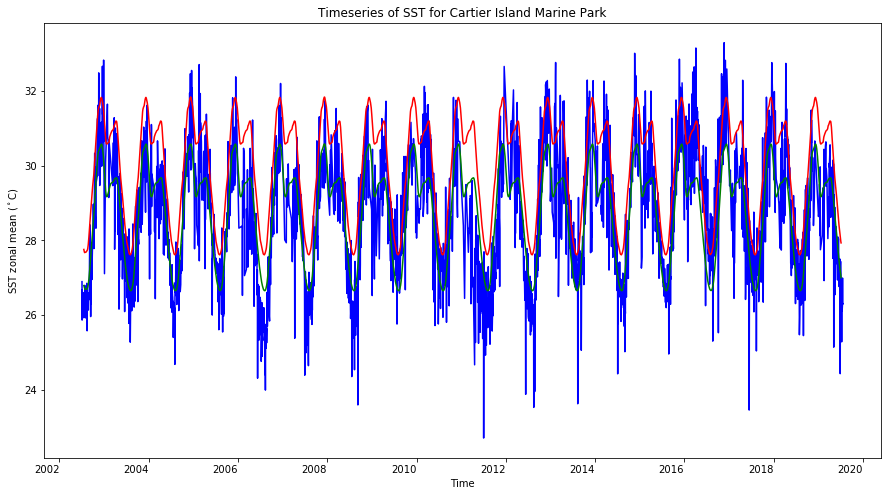

In [22]:
ax=plt.figure(figsize=(15,8))
MODIS_data_cleaned.sst_mean_interp.plot(color='b');
MODIS_data_cleaned.zonal_90.plot(color='r');
MODIS_data_cleaned.zonal_mean.plot(color='g');
plt.xticks(rotation='horizontal');
plt.xlabel('Time');
plt.ylabel('SST zonal mean ($^\circ$C)');
plt.title('Timeseries of SST for ' + AMP_name + ' Marine Park');

### the main function to conduct the MHW analysis from the overall daily SST time-series of the marine park

In [23]:

def do_analysis_zonal(MODISData,amp,outDir):
   
    # create a dataframe to store the MHW characteristics for each point
    mhwDF1 = pd.DataFrame()
    idList = [] # PointID
    noEvents = [] # total number of MHWs events, within the study period
    noDays = [] # total number of MHWs days, within the study period
    totalIntensity = [] # tota accumulated MHWs intensity (oC)
    overallIntensity = [] # overall mean MHWs intensity (oC)
    
    # the event with the highest intensity
    highestIntensity = [] # the maximum intensity of the event (oC)
    date_start_HI = [] # # the start date of the event (as the day number since 20150101)
    duration_HI = [] # the duration of the event
    
    # the event with the longest duration
    largestDuration = [] # the duration of the event 
    date_start_LD = [] # the start date of the event (as the day number since 20150101)
    intensityLD = [] # the mean intensity of the event
    
    # the event with the largest mean intensity
    largestMeanIntensity = [] # the mean intensity of event
    date_start_LMI = [] # the start day of the event (as the day number since 20150101)
    duration_LMI = [] # the duration of the event
    
    # the event with the largest cumulative intensity
    largestCumIntensity = [] # the cumulative intensity of the event
    date_start_LCI = [] # the start day of the event (as the day number since 20150101)
    duration_LCI = [] # the duration of the event
    
    # the MHW classification, based on Hobday et al. (2018)
    totalMoList = [] # total moderate MHW days
    totalStList = [] # total strong MHW days
    totalSeList = [] # total severe MHW days
    totalExList = [] # total extreme MHW days
    
    # daily MHW intensity
    statsDF = pd.DataFrame()
    statsDF['date'] = MODISData.time.dt.strftime('%Y%m%d')
    statsDF.set_index('date',inplace=True)
    
    # daily MHW classification
    statsClassDF = pd.DataFrame()
    statsClassDF['date'] = MODISData.time.dt.strftime('%Y%m%d')
    statsClassDF.set_index('date',inplace=True)
    
    # a dummy id
    id = 'meanI'
    idList.append(id)
    # create a dataframe to store characteristics of the MHWs events identified for this point
    mhwE = pd.DataFrame()
    date_start = []
    date_end = []
    duration = []

    # get the point values as a numpy array, the empty value is NaN
    # the point values are the differences between the interpolated SST values and the 90th climatology
    point1 = MODISData.sst_mean_interp - MODISData.zonal_90
    point1V = point1.values
    # get the dates values
    dates = MODISData.time.dt.strftime('%Y%m%d').values

    # get the threshold values as a numpy array, the empty value is NaN
    # the threshold values are differences between the 90th and the mean climatology
    threshold1 = MODISData.zonal_90 - MODISData.zonal_mean
    threshold1V = threshold1.values

    # replace the NaN values with '-9999'
    point1V_1 = np.where(np.isnan(point1V),-9999,point1V)
    # convert negative values into 0 and positive values into 1
    point1V_1[point1V_1<=0] = False
    point1V_1[point1V_1>0] = True
    # label events: positive value(s)
    events, n_events = label(point1V_1)
 
    for ev in range(1,n_events+1):
        # calculate duration of an event
        event_duration = (events == ev).sum()
        # initially identify all events with duration of 4+ days
        # isolated 4-day event(s) will be eventually removed
        if event_duration > 3:
            date_start.append(dates[np.where(events == ev)[0][0]])
            date_end.append(dates[np.where(events == ev)[0][-1]])
            duration.append(event_duration)
    # the initial list of mhwE
    mhwE['date_start'] = date_start
    mhwE['date_end'] = date_end
    mhwE['duration'] = duration

    # combine ajacent event(s) if they satisfy the criteria, this creates an updated list
    i = 0
    while i < mhwE.index.size - 1:
        date1 = str(mhwE.iloc[i]['date_start'])
        date2 = str(mhwE.iloc[i]['date_end'])
        gap = np.where(dates == date2)[0] - np.where(dates == date1)[0] + 1
        if gap < 3:
            # condition 1: [>=5 hot, 1 cool, 4 hot]; condition 2: [4 hot, 1 cool, >=5 hot]; condition 3: [>=5 hot, 1 cool, >=5 hot]
            if (mhwE.iloc[i]['duration'] >= 5 and mhwE.iloc[i+1]['duration'] == 4) or  (mhwE.iloc[i]['duration'] == 4 and mhwE.iloc[i+1]['duration'] >=5) or  (mhwE.iloc[i]['duration'] >= 5 and mhwE.iloc[i+1]['duration'] >= 5):
                mhwE['date_end'][i] = mhwE['date_end'][i+1]
                mhwE = mhwE.drop(i+1)
                mhwE = mhwE.reset_index(drop=True)
                i = i
            else:
                i = i + 1
        elif gap < 4:
            # condition 4: [>=5 hot, 2 cool, >=5 hot]
            if (mhwE.iloc[i]['duration'] >= 5 and mhwE.iloc[i+1]['duration'] >= 5):              
                mhwE['date_end'][i] = mhwE['date_end'][i+1]
                mhwE = mhwE.drop(i+1)
                mhwE = mhwE.reset_index(drop=True)
                i = i
            else:
                i = i + 1
        else:
            i = i + 1

    # drop the isolated event(s) with a duration of 4 days from the list
    i = 0
    while i < mhwE.index.size:
        date1 = str(mhwE.iloc[i]['date_start'])
        date2 = str(mhwE.iloc[i]['date_end'])
        duration = np.where(dates == date2)[0] - np.where(dates == date1)[0] + 1
        if duration == 4:
            mhwE = mhwE.drop(i)
            mhwE = mhwE.reset_index(drop=True)
            i = i
        else:
            i = i + 1

    # update the durations of the final list
    i = 0
    while i < mhwE.index.size:
        date1 = str(mhwE.iloc[i]['date_start'])
        date2 = str(mhwE.iloc[i]['date_end'])
        duration = np.where(dates == date2)[0] - np.where(dates == date1)[0] + 1
        mhwE['duration'][i] = duration
        i = i + 1

    # calculate mhw properties: intensity max, intensity mean, intensity std, 
    # cumulative intensity, onset rate and decline rate
    intensity_max = []
    intensity_mean = []
    intensity_std = []
    intensity_cumulative = []
    moderateD = []
    strongD = []
    severeD = []
    extremeD = []
    onset_rate = []
    decline_rate = []
    i = 0
    
    while i < mhwE.index.size:
        moderate = 0
        strong = 0
        severe = 0
        extreme = 0

        intensity_values = []
        date_values = []
        startDate = mhwE.iloc[i]['date_start']
        endDate = mhwE.iloc[i]['date_end']
        duration = mhwE.iloc[i]['duration']

        j = 0
        while j < dates.size:

            date1 = dates[j]
            if startDate == date1:
                k = j + int(duration)

                while j < k:
                    sst_diff = point1V[j]
                    # calculate MHW classification
                    threshold = threshold1V[j]
                    ratio = sst_diff / threshold
                    if (ratio >= 0) & (ratio < 1.0):
                        moderate += 1
                    elif ratio < 2.0:
                        strong += 1
                    elif ratio < 3.0:
                        severe += 1
                    else:
                        extreme += 1

                    intensity_values.append(sst_diff)
                    dateV = dates[j]
                    date_values.append(dateV)
                    j = j + 1
            else:
                j = j + 1
      
        np_intensity = np.array(intensity_values)
        np_date = np.array(date_values)

        startDiff = np_intensity[0]
        endDiff = np_intensity[-1]
        maxDiff = np_intensity.max()
        meanDiff = np_intensity.mean()
        stdDiff = np_intensity.std()
        cumDiff = np_intensity.sum()

        peakDate = np_date[np_intensity == maxDiff][0]

        dateDiff1 = (datetime.strptime(str(peakDate),'%Y%m%d') - 
                    datetime.strptime(str(startDate),'%Y%m%d')).days
        if dateDiff1 > 0:        
            rateOnset = (maxDiff - startDiff) / dateDiff1
        else: # the start date is the peak date
            rateOnset = maxDiff / 0.5

        dateDiff2 = (datetime.strptime(str(endDate),'%Y%m%d') - 
                    datetime.strptime(str(peakDate),'%Y%m%d')).days
        if dateDiff2 > 0:        
            rateDecline = (maxDiff - endDiff) / dateDiff2
        else: # the end date is the peak date
            rateDecline = maxDiff / 0.5
            
        intensity_max.append(maxDiff)
        intensity_mean.append(meanDiff)
        intensity_std.append(stdDiff)
        intensity_cumulative.append(cumDiff)

        onset_rate.append(rateOnset)
        decline_rate.append(rateDecline)

        moderateD.append(moderate)
        strongD.append(strong)
        severeD.append(severe)
        extremeD.append(extreme)

        i = i + 1

    mhwE['maxIntensity'] = intensity_max
    mhwE['meanIntensity'] = intensity_mean
    mhwE['stdIntensity'] = intensity_std
    mhwE['cumIntensity'] = intensity_cumulative

    mhwE['onsetRate'] = onset_rate
    mhwE['declineRate'] = decline_rate

    mhwE['moderate'] = moderateD
    mhwE['strong'] = strongD
    mhwE['severe'] = severeD
    mhwE['extreme'] = extremeD

    # save the MHWs events identified for the point into a CSV file
    filename = os.path.join(outDir, 'mhw_' + str(id) + '.csv')
    mhwE.to_csv(filename, sep=',', index=False)

    # generate a statsDF to extract the intensity for the days identified as part of a MHW
    # generate a statsClassDF to extract the MHW classification for the days identified as part of a MHW
    if mhwE.index.size > 0:
        statsDF[str(id)] = np.nan
        statsClassDF[str(id)] = np.nan
        for j in mhwE.index:    
            date_start = str(int(mhwE.loc[j]['date_start']))
            date_end = str(int(mhwE.loc[j]['date_end']))
            x = point1.sel(time=slice(date_start,date_end)).values
            y = threshold1.sel(time=slice(date_start,date_end)).values
            # 2 -> moderate MHW; 3 -> strong MHW; 4 -> severe MHW; 5 -> extreme MHW
            z = np.array(x/y+2,dtype=int) # convert floating point to integer
            statsDF.loc[date_start:date_end,str(id)] = x
            statsClassDF.loc[date_start:date_end,str(id)] = z


#   geneate the summary characteristics of the MHWs    

    if mhwE.index.size > 0:

        noEvents.append(mhwE.index.size)
        noDays.append(mhwE['duration'].sum())
        totalIntensity.append(mhwE['cumIntensity'].sum())
        overallIntensity.append(mhwE['cumIntensity'].sum()/mhwE['duration'].sum())

        totalMoList.append(mhwE['moderate'].sum())
        totalStList.append(mhwE['strong'].sum())
        totalSeList.append(mhwE['severe'].sum())
        totalExList.append(mhwE['extreme'].sum())

        tempDate = mhwE[mhwE['maxIntensity'] == mhwE['maxIntensity'].max()].iloc[0]['date_start']
        HIDate = pd.to_datetime(tempDate, format='%Y%m%d').toordinal() - 735599 # date number since 20150101
        HIDuration = mhwE[mhwE['maxIntensity'] == mhwE['maxIntensity'].max()].iloc[0]['duration']
        highestIntensity.append(mhwE['maxIntensity'].max())
        date_start_HI.append(HIDate)
        duration_HI.append(HIDuration)

        tempDate = mhwE[mhwE['duration'] == mhwE['duration'].max()].iloc[0]['date_start']
        LDDate = pd.to_datetime(tempDate, format='%Y%m%d').toordinal() - 735599
        intensityLDV = mhwE[mhwE['duration'] == mhwE['duration'].max()].iloc[0]['meanIntensity']
        largestDuration.append(mhwE['duration'].max())
        date_start_LD.append(LDDate)
        intensityLD.append(intensityLDV)


        tempDate = mhwE[mhwE['meanIntensity'] == mhwE['meanIntensity'].max()].iloc[0]['date_start']
        LMIDate = pd.to_datetime(tempDate, format='%Y%m%d').toordinal() - 735599
        LMIDuration = mhwE[mhwE['meanIntensity'] == mhwE['meanIntensity'].max()].iloc[0]['duration']
        largestMeanIntensity.append(mhwE['meanIntensity'].max())
        date_start_LMI.append(LMIDate)
        duration_LMI.append(LMIDuration)    


        tempDate = mhwE[mhwE['cumIntensity'] == mhwE['cumIntensity'].max()].iloc[0]['date_start']
        LCIDate = pd.to_datetime(tempDate, format='%Y%m%d').toordinal() - 735599
        LCIDuration = mhwE[mhwE['cumIntensity'] == mhwE['cumIntensity'].max()].iloc[0]['duration']
        largestCumIntensity.append(mhwE['cumIntensity'].max())
        date_start_LCI.append(LCIDate)
        duration_LCI.append(LCIDuration)
    else:
        noEvents.append(0)
        noDays.append(0)
        totalIntensity.append(0)
        overallIntensity.append(0)

        totalMoList.append(0)
        totalStList.append(0)
        totalSeList.append(0)
        totalExList.append(0)

        highestIntensity.append(0)
        date_start_HI.append(0)
        duration_HI.append(0)


        largestDuration.append(0)
        date_start_LD.append(0)
        intensityLD.append(0)


        largestMeanIntensity.append(0)
        date_start_LMI.append(0)
        duration_LMI.append(0)

        largestCumIntensity.append(0)
        date_start_LCI.append(0)
        duration_LCI.append(0)            
        
        
    # populate the dataframe 
    mhwDF1['pointID'] = idList
    
    mhwDF1['noEvents'] = noEvents
    mhwDF1['noDays'] = noDays
    mhwDF1['totalIntensity'] = totalIntensity
    mhwDF1['overallIntensity'] = overallIntensity
    
    mhwDF1['highestIntensity'] = highestIntensity
    mhwDF1['date_start_HI'] = date_start_HI
    mhwDF1['duration_HI'] = duration_HI
    
    mhwDF1['largestDuration'] = largestDuration
    mhwDF1['date_start_LD'] = date_start_LD
    mhwDF1['intensityLD'] = intensityLD
    
    mhwDF1['largestMeanIntensity'] = largestMeanIntensity
    mhwDF1['date_start_LMI'] = date_start_LMI
    mhwDF1['duration_LMI'] = duration_LMI
    
    mhwDF1['largestCumIntensity'] = largestCumIntensity
    mhwDF1['date_start_LCI'] = date_start_LCI
    mhwDF1['duration_LCI'] = duration_LCI
    
    mhwDF1['moderate'] = totalMoList
    mhwDF1['strong'] = totalStList
    mhwDF1['severe'] = totalSeList
    mhwDF1['extreme'] = totalExList
          
    # save the summary characteristics to a CSV file
    mhwDF1.to_csv(os.path.join(outDir, 'results_' + amp + '.csv'), sep=',', index=False) 
    
    return mhwE, mhwDF1, statsDF, statsClassDF


### conduct MHW analysis for the marine park, using the overall daily mean SST time-series

In [24]:
time1 = datetime.now()
amp = 'CI'
outdir = '../../' + amp
if os.path.isdir(outdir):
   print(outdir, 'exists') 
else:
    os.mkdir(outdir)

mhwZonal, mhwZonalDF4, statsZonalDF4, statsClassZonalDF4 = do_analysis_zonal(MODIS_data_cleaned,amp,outdir)
time2 = datetime.now()
diff = time2 - time1
print('took',diff, 'to finish')

../../CI exists


/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


took 0:00:00.827272 to finish


### Check the MHW results from the overall daily mean SST time-series of the marine park



the MHW results of individual events

note the properties of the individual events

In [25]:
mhwZonal

,date_start,date_end,duration,maxIntensity,meanIntensity,stdIntensity,cumIntensity,onsetRate,declineRate,moderate,strong,severe,extreme
0,20030118,20030204,18,1.052886,0.396450,0.335785,7.136097,0.104517,0.148591,18,0,0,0
1,20040119,20040124,6,0.519881,0.271024,0.154174,1.626141,0.061425,0.108179,6,0,0,0
2,20041220,20041225,6,0.392962,0.206430,0.125728,1.238582,0.785924,0.073329,6,0,0,0
3,20051009,20051013,5,0.773368,0.504348,0.193536,2.521742,0.262021,0.225068,5,0,0,0
4,20090420,20090426,7,1.041581,0.638623,0.270955,4.470364,0.134574,2.083162,7,0,0,0
5,20090829,20090902,5,0.638020,0.295582,0.190407,1.477912,0.135425,1.276040,5,0,0,0
6,20090914,20090918,5,0.660122,0.353477,0.199464,1.767387,0.344109,0.198423,5,0,0,0
7,20111218,20120115,29,0.944196,0.436371,0.250154,12.654746,0.543250,0.033736,29,0,0,0
8,20120222,20120307,14,1.105031,0.579796,0.309359,8.117140,0.088805,0.304922,14,0,0,0
9,20121122,20121128,7,0.590789,0.493066,0.072323,3.451464,1.181578,0.002898,7,0,0,0


the MHW results summarising all individual events

In [26]:
mhwZonalDF4

,pointID,noEvents,noDays,totalIntensity,overallIntensity,highestIntensity,date_start_HI,duration_HI,largestDuration,date_start_LD,...,largestMeanIntensity,date_start_LMI,duration_LMI,largestCumIntensity,date_start_LCI,duration_LCI,moderate,strong,severe,extreme
0,meanI,26,235,138.689257,0.590167,2.247872,540,20,29,-1110,...,1.186177,433,7,21.022451,540,20,205,29,1,0


#### Add the daily MHW intensity and category values as two variables

In [27]:
MODIS_data_cleaned['zonal_intensity'] = xr.DataArray(statsZonalDF4.meanI,dims='time', coords={'time': MODIS_data_cleaned['time']})

MODIS_data_cleaned['zonal_class'] = xr.DataArray(statsClassZonalDF4.meanI,dims='time', coords={'time': MODIS_data_cleaned['time']})

In [28]:
MODIS_data_cleaned

<xarray.Dataset>
Dimensions:          (latitude: 14, longitude: 15, time: 6210)
Coordinates:
  * time             (time) datetime64[ns] 2002-07-04T11:59:59.999999 ... 2019-07-22T11:59:59.999999
  * latitude         (latitude) float64 -12.47 -12.48 -12.49 ... -12.59 -12.6
  * longitude        (longitude) float64 123.5 123.5 123.5 ... 123.6 123.6 123.6
Data variables:
    sst              (time, latitude, longitude) float32 nan nan nan ... nan nan
    sst_mean         (time) float32 26.897036 25.869576 ... 26.299578 nan
    sst_min          (time) float32 26.605 25.425 26.38 ... 26.305 25.965 nan
    sst_max          (time) float32 27.24 26.31 27.03 nan ... 26.365 26.635 nan
    sst_std          (time) float32 0.14253645 0.18784189 ... 0.13139829 nan
    sst_mean_interp  (time) float32 26.897036 25.869576 ... 26.299578 26.299578
    sst_min_interp   (time) float32 26.605 25.425 26.38 ... 26.305 25.965 25.965
    sst_max_interp   (time) float32 27.24 26.31 27.03 ... 26.365 26.635 26.635
    sst_std_interp   (time) float32 0.14253645 0.18784189 ... 0.13139829
    doy              (time) int64 185 186 187 188 189 ... 199 200 201 202 203
    zonal_90         (time) float64 nan nan nan nan nan ... nan nan nan nan nan
    zonal_mean       (time) float32 nan nan nan nan nan ... nan nan nan nan nan
    zonal_intensity  (time) float64 nan nan nan nan nan ... nan nan nan nan nan
    zonal_class      (time) float64 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    crs:      EPSG:4326

## Identify per-pixel MHWs of the marine park

from daily SST time-series of each pixel

### Calculate per-pixel interpolated SST time-series
First create an empty xarray; then assign the calculated values

In [29]:
x = np.empty((MODIS_data_cleaned.time.size,MODIS_data_cleaned.latitude.size,MODIS_data_cleaned.longitude.size))

x[:] = np.nan

# Create an empty dataset to put our values into
MODIS_data_cleaned['sst_interp'] = xr.DataArray(data=x,
                                       coords={
                                           'time': MODIS_data_cleaned['time'],
                                           'latitude': MODIS_data_cleaned['latitude'],
                                           'longitude': MODIS_data_cleaned['longitude']
                                       },
                                               dims=['time','latitude','longitude'])


In [30]:
# Loop through each lat/lon 
# Calculate the interpolated SST; and add to the dataset
for iix, i in enumerate(MODIS_data_cleaned.latitude):
    for jix, j in enumerate(MODIS_data_cleaned.longitude):
        try:
            MODIS_data_cleaned['sst_interp'][:,iix, jix] = pad(MODIS_data_cleaned.sst[:,iix,jix].values,maxPadLength=2)

        except ValueError: # occurs when the pixel contains nan in the entire time-series
            continue

### calculate the 90th percentile and the mean climatology data for the per-pixel time-series

use 11-days window and smooth it with 31-days running average

In [31]:
x = np.empty((MODIS_data_cleaned.time.size,MODIS_data_cleaned.latitude.size,MODIS_data_cleaned.longitude.size))
x[:] = np.nan

y = np.empty((MODIS_data_cleaned.time.size,MODIS_data_cleaned.latitude.size,MODIS_data_cleaned.longitude.size))
y[:] = np.nan

# Create an empty dataset to put our values into
MODIS_data_cleaned['pixel_90'] = xr.DataArray(data=x,
                                       coords={
                                           'time': MODIS_data_cleaned['time'],
                                           'latitude': MODIS_data_cleaned['latitude'],
                                           'longitude': MODIS_data_cleaned['longitude']
                                       },
                                               dims=['time','latitude','longitude'])
MODIS_data_cleaned['pixel_mean'] = xr.DataArray(data=y,
                                       coords={
                                           'time': MODIS_data_cleaned['time'],
                                           'latitude': MODIS_data_cleaned['latitude'],
                                           'longitude': MODIS_data_cleaned['longitude']
                                       },
                                               dims=['time','latitude','longitude'])


In [32]:
time1 = datetime.now()
# only needs these four variables to work with
tempData = MODIS_data_cleaned.get(['doy','sst_interp','pixel_90','pixel_mean'])

# just use one-year worth data to obtain the dayofyearList and calculate the 90th percentile and mean values
# this speeds up the calculation greatly
data_2003 = tempData.sel(time=slice('2003','2003'))
dayofyearList = []
for doy in data_2003.doy:
    dayofyear = doy

    if dayofyear == 1:
        dayofyears = [361,362,363,364,365,1,2,3,4,5,6]
    elif dayofyear == 2:
        dayofyears = [362,363,364,365,1,2,3,4,5,6,7]
    elif dayofyear == 3:
        dayofyears = [363,364,365,1,2,3,4,5,6,7,8]
    elif dayofyear == 4:
        dayofyears = [364,365,1,2,3,4,5,6,7,8,9]
    elif dayofyear == 5:
        dayofyears = [365,1,2,3,4,5,6,7,8,9,10]
    elif dayofyear == 365:
        dayofyears = [360,361,362,363,364,365,1,2,3,4,5]
    elif dayofyear == 364:
        dayofyears = [359,360,361,362,363,364,365,1,2,3,4]
    elif dayofyear == 363:
        dayofyears = [358,359,360,361,362,363,364,365,1,2,3]
    elif dayofyear == 362:
        dayofyears = [357,358,359,360,361,362,363,364,365,1,2]
    elif dayofyear == 361:
        dayofyears = [356,357,358,359,360,361,362,363,364,365,1]
    else:
        dayofyears = np.arange(dayofyear-5,dayofyear+6,1)
    dayofyearList.append(dayofyears)

# Loop through each lat/lon and calculate the the 90th percentile and the mean
for iix, i in enumerate(data_2003.latitude):
    for jix, j in enumerate(data_2003.longitude):
        if tempData.sst_interp[:,iix,jix].count() == 0: # skip the pixels with nan in the entire time-series
            
            print('skip',iix,jix)
        else:
            #print('doing',iix,jix)
            try:
                nintyList = []
                meanList = []
                doys = tempData.doy.values
                ssts = tempData.sst_interp[:,iix,jix].values
                tempDF = pd.DataFrame()
                tempDF['doy'] = doys
                tempDF['sst'] = ssts
                for dayofyears in dayofyearList:
                    x_90 = tempDF[tempDF.doy.isin(dayofyears)].sst.quantile(0.9)
                    x_mean = tempDF[tempDF.doy.isin(dayofyears)].sst.mean() 
                    nintyList.append(x_90)
                    meanList.append(x_mean)
                
                x = np.asarray(nintyList)
                  
                data_2003['pixel_90'][:,iix,jix] = xr.DataArray(x,dims='time', coords={'time': data_2003['time']})
                
                y = np.asarray(meanList)
                
                data_2003['pixel_mean'][:,iix,jix] = xr.DataArray(y,dims='time', coords={'time': data_2003['time']})
                
            except ValueError:
                continue

# populate the entire dataset from the one-year dataset                
i = 0
for doy in MODIS_data_cleaned.doy:
    
    MODIS_data_cleaned['pixel_90'][i,:,:] = data_2003.where(data_2003.doy==doy,drop=True).pixel_90[0]
    MODIS_data_cleaned['pixel_mean'][i,:,:] = data_2003.where(data_2003.doy==doy,drop=True).pixel_mean[0]
    i += 1    
# apply 31-day rolling window averages to further smooth the climatology   
MODIS_data_cleaned['pixel_90'] = MODIS_data_cleaned.pixel_90.rolling(time=31,center=True).mean()
MODIS_data_cleaned['pixel_mean'] = MODIS_data_cleaned.pixel_mean.rolling(time=31,center=True).mean()

time2 = datetime.now()
diff = time2 - time1
print('took',diff, 'to finish')

skip 0 0
skip 0 1
skip 0 2
skip 0 3
skip 0 4
skip 0 5
skip 0 9
skip 0 10
skip 0 11
skip 0 12
skip 0 13
skip 0 14
skip 1 0
skip 1 1
skip 1 2
skip 1 3
skip 1 11
skip 1 12
skip 1 13
skip 1 14
skip 2 0
skip 2 1
skip 2 2
skip 2 12
skip 2 13
skip 2 14
skip 3 0
skip 3 1
skip 3 13
skip 3 14
skip 4 0
skip 4 14
skip 5 0
skip 5 6
skip 5 7
skip 5 8
skip 5 14
skip 6 0
skip 6 5
skip 6 6
skip 6 7
skip 6 8
skip 6 9
skip 6 10
skip 6 14
skip 7 0
skip 7 4
skip 7 5
skip 7 6
skip 7 7
skip 7 8
skip 7 9
skip 7 10
skip 7 14
skip 8 0
skip 8 5
skip 8 6
skip 8 7
skip 8 8
skip 8 9
skip 8 14
skip 9 0
skip 9 6
skip 9 7
skip 9 14
skip 10 0
skip 10 1
skip 10 13
skip 10 14
skip 11 0
skip 11 1
skip 11 13
skip 11 14
skip 12 0
skip 12 1
skip 12 2
skip 12 3
skip 12 12
skip 12 13
skip 12 14
skip 13 0
skip 13 1
skip 13 2
skip 13 3
skip 13 4
skip 13 5
skip 13 9
skip 13 10
skip 13 11
skip 13 12
skip 13 13
skip 13 14
took 0:03:46.618655 to finish


#### plot the 90th percentile (red) and the mean climatology (green), and the SST time-series (after interpolation) (black)
just to check

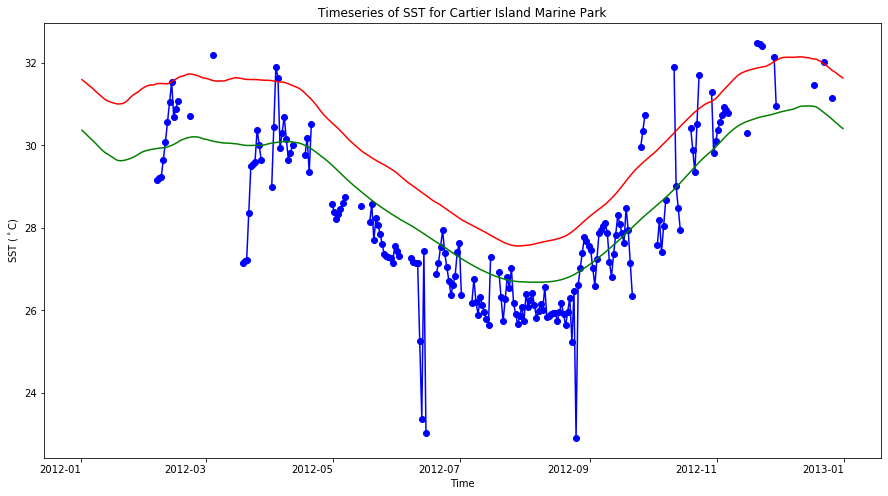

In [33]:
ax=plt.figure(figsize=(15,8))
# only plot one-year time-series at one location for the purpose
MODIS_data_cleaned.sel(time=slice('2012','2012')).sst_interp[:,0,6].plot(color='b',marker='o');
MODIS_data_cleaned.sel(time=slice('2012','2012')).pixel_90[:,0,6].plot(color='r');
MODIS_data_cleaned.sel(time=slice('2012','2012')).pixel_mean[:,0,6].plot(color='g');
plt.xticks(rotation='horizontal');
plt.xlabel('Time');
plt.ylabel('SST ($^\circ$C)');
plt.title('Timeseries of SST for ' + AMP_name + ' Marine Park');

In [34]:
MODIS_data_cleaned

<xarray.Dataset>
Dimensions:          (latitude: 14, longitude: 15, time: 6210)
Coordinates:
  * time             (time) datetime64[ns] 2002-07-04T11:59:59.999999 ... 2019-07-22T11:59:59.999999
  * latitude         (latitude) float64 -12.47 -12.48 -12.49 ... -12.59 -12.6
  * longitude        (longitude) float64 123.5 123.5 123.5 ... 123.6 123.6 123.6
Data variables:
    sst              (time, latitude, longitude) float32 nan nan nan ... nan nan
    sst_mean         (time) float32 26.897036 25.869576 ... 26.299578 nan
    sst_min          (time) float32 26.605 25.425 26.38 ... 26.305 25.965 nan
    sst_max          (time) float32 27.24 26.31 27.03 nan ... 26.365 26.635 nan
    sst_std          (time) float32 0.14253645 0.18784189 ... 0.13139829 nan
    sst_mean_interp  (time) float32 26.897036 25.869576 ... 26.299578 26.299578
    sst_min_interp   (time) float32 26.605 25.425 26.38 ... 26.305 25.965 25.965
    sst_max_interp   (time) float32 27.24 26.31 27.03 ... 26.365 26.635 26.635
    sst_std_interp   (time) float32 0.14253645 0.18784189 ... 0.13139829
    doy              (time) int64 185 186 187 188 189 ... 199 200 201 202 203
    zonal_90         (time) float64 nan nan nan nan nan ... nan nan nan nan nan
    zonal_mean       (time) float32 nan nan nan nan nan ... nan nan nan nan nan
    zonal_intensity  (time) float64 nan nan nan nan nan ... nan nan nan nan nan
    zonal_class      (time) float64 nan nan nan nan nan ... nan nan nan nan nan
    sst_interp       (time, latitude, longitude) float64 nan nan nan ... nan nan
    pixel_90         (time, latitude, longitude) float64 nan nan nan ... nan nan
    pixel_mean       (time, latitude, longitude) float64 nan nan nan ... nan nan
Attributes:
    crs:      EPSG:4326

### The main function to identify the per-pixel MHW events and generate statistics. 



In [35]:
# take the MODIS dataset as input, and add new variables to it
def do_analysis(MODISData,amp,outDir):   
     # total number of MHWs events, within the study period
     # Create empty xarray variables to put our values into
    MODISData['noEvents'] = xr.DataArray(data=np.nan * MODISData['latitude'] *
                                           MODISData['longitude'],
                                           coords={
                                               'latitude': MODISData['latitude'],
                                               'longitude': MODISData['longitude']
                                           })
   # total number of MHWs days, within the study period
    MODISData['noDays'] = xr.DataArray(data=np.nan * MODISData['latitude'] *
                                           MODISData['longitude'],
                                           coords={
                                               'latitude': MODISData['latitude'],
                                               'longitude': MODISData['longitude']
                                           })
    # tota accumulated MHWs intensity (oC)
    MODISData['totalIntensity'] = xr.DataArray(data=np.nan * MODISData['latitude'] *
                                           MODISData['longitude'],
                                           coords={
                                               'latitude': MODISData['latitude'],
                                               'longitude': MODISData['longitude']
                                           })    
    # overall mean MHWs intensity (oC)
    MODISData['overallIntensity'] = xr.DataArray(data=np.nan * MODISData['latitude'] *
                                           MODISData['longitude'],
                                           coords={
                                               'latitude': MODISData['latitude'],
                                               'longitude': MODISData['longitude']
                                           })    
    ## the event with the highest intensity
    # the maximum intensity of the event (oC)
    MODISData['highestIntensity'] = xr.DataArray(data=np.nan * MODISData['latitude'] *
                                           MODISData['longitude'],
                                           coords={
                                               'latitude': MODISData['latitude'],
                                               'longitude': MODISData['longitude']
                                           })
    # the start date of the event (as the day number since 20150101)
    MODISData['date_start_HI'] = xr.DataArray(data=np.nan * MODISData['latitude'] *
                                           MODISData['longitude'],
                                           coords={
                                               'latitude': MODISData['latitude'],
                                               'longitude': MODISData['longitude']
                                           })
    # the duration of the event
    MODISData['duration_HI'] = xr.DataArray(data=np.nan * MODISData['latitude'] *
                                           MODISData['longitude'],
                                           coords={
                                               'latitude': MODISData['latitude'],
                                               'longitude': MODISData['longitude']
                                           })    
    ## the event with the longest duration
    # the duration of the event 
    MODISData['largestDuration'] = xr.DataArray(data=np.nan * MODISData['latitude'] *
                                           MODISData['longitude'],
                                           coords={
                                               'latitude': MODISData['latitude'],
                                               'longitude': MODISData['longitude']
                                           })
    # the start date of the event (as the day number since 20150101)
    MODISData['date_start_LD'] = xr.DataArray(data=np.nan * MODISData['latitude'] *
                                           MODISData['longitude'],
                                           coords={
                                               'latitude': MODISData['latitude'],
                                               'longitude': MODISData['longitude']
                                           })
    # the mean intensity of the event
    MODISData['intensityLD'] = xr.DataArray(data=np.nan * MODISData['latitude'] *
                                           MODISData['longitude'],
                                           coords={
                                               'latitude': MODISData['latitude'],
                                               'longitude': MODISData['longitude']
                                           })    
    ## the event with the largest mean intensity
    # the mean intensity of event
    MODISData['largestMeanIntensity'] = xr.DataArray(data=np.nan * MODISData['latitude'] *
                                           MODISData['longitude'],
                                           coords={
                                               'latitude': MODISData['latitude'],
                                               'longitude': MODISData['longitude']
                                           })
    # the start day of the event (as the day number since 20150101)
    MODISData['date_start_LMI'] = xr.DataArray(data=np.nan * MODISData['latitude'] *
                                           MODISData['longitude'],
                                           coords={
                                               'latitude': MODISData['latitude'],
                                               'longitude': MODISData['longitude']
                                           })
    # the duration of the event
    MODISData['duration_LMI'] = xr.DataArray(data=np.nan * MODISData['latitude'] *
                                           MODISData['longitude'],
                                           coords={
                                               'latitude': MODISData['latitude'],
                                               'longitude': MODISData['longitude']
                                           })    
    ## the event with the largest cumulative intensity
    # the cumulative intensity of the event
    MODISData['largestCumIntensity'] = xr.DataArray(data=np.nan * MODISData['latitude'] *
                                           MODISData['longitude'],
                                           coords={
                                               'latitude': MODISData['latitude'],
                                               'longitude': MODISData['longitude']
                                           })
    # the start day of the event (as the day number since 20150101)
    MODISData['date_start_LCI'] = xr.DataArray(data=np.nan * MODISData['latitude'] *
                                           MODISData['longitude'],
                                           coords={
                                               'latitude': MODISData['latitude'],
                                               'longitude': MODISData['longitude']
                                           })
    # the duration of the event
    MODISData['duration_LCI'] = xr.DataArray(data=np.nan * MODISData['latitude'] *
                                           MODISData['longitude'],
                                           coords={
                                               'latitude': MODISData['latitude'],
                                               'longitude': MODISData['longitude']
                                           })    
    # the MHW classification, based on Hobday et al. (2018)
    # total moderate MHW days
    MODISData['total_Moderate'] = xr.DataArray(data=np.nan * MODISData['latitude'] *
                                           MODISData['longitude'],
                                           coords={
                                               'latitude': MODISData['latitude'],
                                               'longitude': MODISData['longitude']
                                           })
    # total strong MHW days
    MODISData['total_Strong'] = xr.DataArray(data=np.nan * MODISData['latitude'] *
                                           MODISData['longitude'],
                                           coords={
                                               'latitude': MODISData['latitude'],
                                               'longitude': MODISData['longitude']
                                           })
    # total severe MHW days
    MODISData['total_Severe'] = xr.DataArray(data=np.nan * MODISData['latitude'] *
                                           MODISData['longitude'],
                                           coords={
                                               'latitude': MODISData['latitude'],
                                               'longitude': MODISData['longitude']
                                           })
    # total extreme MHW days
    MODISData['total_Extreme'] = xr.DataArray(data=np.nan * MODISData['latitude'] *
                                           MODISData['longitude'],
                                           coords={
                                               'latitude': MODISData['latitude'],
                                               'longitude': MODISData['longitude']
                                           })
     # Create empty variables to put our values into
    x = np.empty((MODISData.time.size,MODISData.latitude.size,MODISData.longitude.size))
    x[:] = np.nan

    y = np.empty((MODISData.time.size,MODISData.latitude.size,MODISData.longitude.size))
    y[:] = np.nan

    # per-pixel MHW intensity
    MODISData['pixel_intensity'] = xr.DataArray(data=x,
                                           coords={
                                               'time': MODISData['time'],
                                               'latitude': MODISData['latitude'],
                                               'longitude': MODISData['longitude']
                                           },
                                                   dims=['time','latitude','longitude'])
    # per-pixel MHW category
    MODISData['pixel_class'] = xr.DataArray(data=y,
                                           coords={
                                               'time': MODISData['time'],
                                               'latitude': MODISData['latitude'],
                                               'longitude': MODISData['longitude']
                                           },
                                                   dims=['time','latitude','longitude'])
    

    
    # loop through each pixel (point)
    for iix,m in enumerate(MODISData.latitude):
        for jix,n in enumerate(MODISData.longitude):
            if MODISData.sst_interp[:,iix,jix].count() == 0:

                print('skip',iix,jix)
            else:
                #print('doing', iix,jix)

                # create a dataframe to store characteristics of the MHWs events identified for this point
                mhwE = pd.DataFrame()
                date_start = []
                date_end = []
                duration = []

                # get the point values as a numpy array, the empty value is NaN
                point1 = MODISData.sst_interp[:,iix,jix] - MODISData.pixel_90[:,iix,jix]
                point1V = point1.values
                dates = MODISData.time.dt.strftime('%Y%m%d').values

                # get the threshold values as a numpy array, the empty value is NaN
                threshold1 = MODISData.pixel_90[:,iix,jix] - MODISData.pixel_mean[:,iix,jix]
                threshold1V = threshold1.values


                # replace the NaN values with '-9999'
                point1V_1 = np.where(np.isnan(point1V),-9999,point1V)
                # convert negative values into 0 and positive values into 1
                point1V_1[point1V_1<=0] = False
                point1V_1[point1V_1>0] = True

                # label events: positive value(s)       
                events, n_events = label(point1V_1)

                for ev in range(1,n_events+1):
                    # calculate duration of an event
                    event_duration = (events == ev).sum()
                    # initially identify all events with duration of 4+ days
                    # isolated 4-day event(s) will be eventually removed
                    if event_duration > 3:
                        date_start.append(dates[np.where(events == ev)[0][0]])
                        date_end.append(dates[np.where(events == ev)[0][-1]])
                        duration.append(event_duration)
                # the initial list of mhwE
                mhwE['date_start'] = date_start
                mhwE['date_end'] = date_end
                mhwE['duration'] = duration

                # combine ajacent event(s) if they satisfy the criteria, this creates an updated list
                i = 0
                while i < mhwE.index.size - 1:
                    date1 = str(mhwE.iloc[i]['date_start'])
                    date2 = str(mhwE.iloc[i]['date_end'])
                    gap = np.where(dates == date2)[0] - np.where(dates == date1)[0] + 1
                    if gap < 3:
                        # condition 1: [>=5 hot, 1 cool, 4 hot]; condition 2: [4 hot, 1 cool, >=5 hot]; condition 3: [>=5 hot, 1 cool, >=5 hot]
                        if (mhwE.iloc[i]['duration'] >= 5 and mhwE.iloc[i+1]['duration'] == 4) or  (mhwE.iloc[i]['duration'] == 4 and mhwE.iloc[i+1]['duration'] >=5) or  (mhwE.iloc[i]['duration'] >= 5 and mhwE.iloc[i+1]['duration'] >= 5):
                            mhwE['date_end'][i] = mhwE['date_end'][i+1]
                            mhwE = mhwE.drop(i+1)
                            mhwE = mhwE.reset_index(drop=True)
                            i = i
                        else:
                            i = i + 1
                    elif gap < 4:
                        # condition 4: [>=5 hot, 2 cool, >=5 hot]
                        if (mhwE.iloc[i]['duration'] >= 5 and mhwE.iloc[i+1]['duration'] >= 5):              
                            mhwE['date_end'][i] = mhwE['date_end'][i+1]
                            mhwE = mhwE.drop(i+1)
                            mhwE = mhwE.reset_index(drop=True)
                            i = i
                        else:
                            i = i + 1
                    else:
                        i = i + 1

                # drop the isolated event(s) with a duration of 4 days from the list
                i = 0
                while i < mhwE.index.size:
                    date1 = str(mhwE.iloc[i]['date_start'])
                    date2 = str(mhwE.iloc[i]['date_end'])
                    duration = np.where(dates == date2)[0] - np.where(dates == date1)[0] + 1
                    if duration == 4:
                        mhwE = mhwE.drop(i)
                        mhwE = mhwE.reset_index(drop=True)
                        i = i
                    else:
                        i = i + 1

                # update the durations of the final list
                i = 0
                while i < mhwE.index.size:
                    date1 = str(mhwE.iloc[i]['date_start'])
                    date2 = str(mhwE.iloc[i]['date_end'])
                    duration = np.where(dates == date2)[0] - np.where(dates == date1)[0] + 1
                    mhwE['duration'][i] = duration
                    i = i + 1

                # calculate mhw properties: intensity max, intensity mean, intensity std, 
                # cumulative intensity, onset rate and decline rate
                intensity_max = []
                intensity_mean = []
                intensity_std = []
                intensity_cumulative = []
                moderateD = []
                strongD = []
                severeD = []
                extremeD = []

                onset_rate = []
                decline_rate = []
                i = 0        

                while i < mhwE.index.size:
                    moderate = 0
                    strong = 0
                    severe = 0
                    extreme = 0

                    intensity_values = []
                    date_values = []
                    startDate = mhwE.iloc[i]['date_start']
                    endDate = mhwE.iloc[i]['date_end']
                    duration = mhwE.iloc[i]['duration']

                    j = 0
                    while j < dates.size:

                        date1 = dates[j]
                        if startDate == date1:
                            k = j + int(duration)

                            while j < k:
                                sst_diff = point1V[j]
                                # calculate MHW classification
                                threshold = threshold1V[j]
                                ratio = sst_diff / threshold
                                if (ratio >= 0) & (ratio < 1.0):
                                    moderate += 1
                                elif ratio < 2.0:
                                    strong += 1
                                elif ratio < 3.0:
                                    severe += 1
                                else:
                                    extreme += 1

                                intensity_values.append(sst_diff)
                                dateV = dates[j]
                                date_values.append(dateV)
                                j = j + 1
                        else:
                            j = j + 1

                    np_intensity = np.array(intensity_values)
                    np_date = np.array(date_values)

                    startDiff = np_intensity[0]
                    endDiff = np_intensity[-1]
                    maxDiff = np_intensity.max()
                    meanDiff = np_intensity.mean()
                    stdDiff = np_intensity.std()
                    cumDiff = np_intensity.sum()

                    peakDate = np_date[np_intensity == maxDiff][0]

                    dateDiff1 = (datetime.strptime(str(peakDate),'%Y%m%d') - 
                                datetime.strptime(str(startDate),'%Y%m%d')).days
                    if dateDiff1 > 0:        
                        rateOnset = (maxDiff - startDiff) / dateDiff1
                    else: # the start date is the peak date
                        rateOnset = maxDiff / 0.5

                    dateDiff2 = (datetime.strptime(str(endDate),'%Y%m%d') - 
                                datetime.strptime(str(peakDate),'%Y%m%d')).days
                    if dateDiff2 > 0:        
                        rateDecline = (maxDiff - endDiff) / dateDiff2
                    else: # the end date is the peak date
                        rateDecline = maxDiff / 0.5

                    intensity_max.append(maxDiff)
                    intensity_mean.append(meanDiff)
                    intensity_std.append(stdDiff)
                    intensity_cumulative.append(cumDiff)

                    onset_rate.append(rateOnset)
                    decline_rate.append(rateDecline)

                    moderateD.append(moderate)
                    strongD.append(strong)
                    severeD.append(severe)
                    extremeD.append(extreme)

                    i = i + 1

                mhwE['maxIntensity'] = intensity_max
                mhwE['meanIntensity'] = intensity_mean
                mhwE['stdIntensity'] = intensity_std
                mhwE['cumIntensity'] = intensity_cumulative

                mhwE['onsetRate'] = onset_rate
                mhwE['declineRate'] = decline_rate

                mhwE['moderate'] = moderateD
                mhwE['strong'] = strongD
                mhwE['severe'] = severeD
                mhwE['extreme'] = extremeD

                # save the MHWs events identified for the point into a CSV file
                filename = os.path.join(outDir, 'mhw_' + str(iix) + '_' + str(jix) + '.csv')
                mhwE.to_csv(filename, sep=',', index=False)
                
                # populate per-pixel MHW intensity and category for the days identified as part of a MHW
                
                if mhwE.index.size > 0:

                    for j in mhwE.index:    
                        date_start = str(int(mhwE.loc[j]['date_start']))
                        date_end = str(int(mhwE.loc[j]['date_end']))
                        x = point1.sel(time=slice(date_start,date_end)).values
                        y = threshold1.sel(time=slice(date_start,date_end)).values
                        # 2 -> moderate MHW; 3 -> strong MHW; 4 -> severe MHW; 5 -> extreme MHW
                        z = np.array(x/y+2,dtype=int) # convert floating point to integer
                        MODISData.sel(time=slice(date_start,date_end)).pixel_intensity[:,iix,jix] = x
                        MODISData.sel(time=slice(date_start,date_end)).pixel_class[:,iix,jix] = z

   


            #   geneate the summary characteristics of the MHWs and populate the empty varaibles   

                if mhwE.index.size > 0:

                    MODISData['noEvents'][iix,jix] = mhwE.index.size
                    MODISData['noDays'][iix,jix] = mhwE['duration'].sum()
                    MODISData['totalIntensity'][iix,jix] = mhwE['cumIntensity'].sum()
                    MODISData['overallIntensity'][iix,jix] = mhwE['cumIntensity'].sum()/mhwE['duration'].sum()

                    MODISData['total_Moderate'][iix,jix] = mhwE['moderate'].sum()
                    MODISData['total_Strong'][iix,jix] = mhwE['strong'].sum()
                    MODISData['total_Severe'][iix,jix] = mhwE['severe'].sum()
                    MODISData['total_Extreme'][iix,jix] = mhwE['extreme'].sum()                    

                    tempDate = mhwE[mhwE['maxIntensity'] == mhwE['maxIntensity'].max()].iloc[0]['date_start']
                    HIDate = pd.to_datetime(tempDate, format='%Y%m%d').toordinal() - 735599 # date number since 20150101
                    HIDuration = mhwE[mhwE['maxIntensity'] == mhwE['maxIntensity'].max()].iloc[0]['duration']
                    MODISData['highestIntensity'][iix,jix] = mhwE['maxIntensity'].max()
                    MODISData['date_start_HI'][iix,jix] = HIDate
                    MODISData['duration_HI'][iix,jix] = HIDuration

                    tempDate = mhwE[mhwE['duration'] == mhwE['duration'].max()].iloc[0]['date_start']
                    LDDate = pd.to_datetime(tempDate, format='%Y%m%d').toordinal() - 735599
                    intensityLDV = mhwE[mhwE['duration'] == mhwE['duration'].max()].iloc[0]['meanIntensity']
                    MODISData['largestDuration'][iix,jix] = mhwE['duration'].max()
                    MODISData['date_start_LD'][iix,jix] = LDDate
                    MODISData['intensityLD'][iix,jix] = intensityLDV


                    tempDate = mhwE[mhwE['meanIntensity'] == mhwE['meanIntensity'].max()].iloc[0]['date_start']
                    LMIDate = pd.to_datetime(tempDate, format='%Y%m%d').toordinal() - 735599
                    LMIDuration = mhwE[mhwE['meanIntensity'] == mhwE['meanIntensity'].max()].iloc[0]['duration']
                    MODISData['largestMeanIntensity'][iix,jix] = mhwE['meanIntensity'].max()
                    MODISData['date_start_LMI'][iix,jix] = LMIDate
                    MODISData['duration_LMI'][iix,jix] = LMIDuration    


                    tempDate = mhwE[mhwE['cumIntensity'] == mhwE['cumIntensity'].max()].iloc[0]['date_start']
                    LCIDate = pd.to_datetime(tempDate, format='%Y%m%d').toordinal() - 735599
                    LCIDuration = mhwE[mhwE['cumIntensity'] == mhwE['cumIntensity'].max()].iloc[0]['duration']
                    MODISData['largestCumIntensity'][iix,jix] = mhwE['cumIntensity'].max()
                    MODISData['date_start_LCI'][iix,jix] = LCIDate
                    MODISData['duration_LCI'][iix,jix] = LCIDuration
                else:

                    MODISData['noEvents'][iix,jix] = 0
                    MODISData['noDays'][iix,jix] = 0
                    MODISData['totalIntensity'][iix,jix] = 0
                    MODISData['overallIntensity'][iix,jix] = 0

                    MODISData['total_Moderate'][iix,jix] = 0
                    MODISData['total_Strong'][iix,jix] = 0
                    MODISData['total_Severe'][iix,jix] = 0
                    MODISData['total_Extreme'][iix,jix] = 0                    


                    MODISData['highestIntensity'][iix,jix] = 0
                    MODISData['date_start_HI'][iix,jix] = 0
                    MODISData['duration_HI'][iix,jix] = 0


                    MODISData['largestDuration'][iix,jix] = 0
                    MODISData['date_start_LD'][iix,jix] = 0
                    MODISData['intensityLD'][iix,jix] = 0



                    MODISData['largestMeanIntensity'][iix,jix] = 0
                    MODISData['date_start_LMI'][iix,jix] = 0
                    MODISData['duration_LMI'][iix,jix] = 0    


                    MODISData['largestCumIntensity'][iix,jix] = 0
                    MODISData['date_start_LCI'][iix,jix] = 0
                    MODISData['duration_LCI'][iix,jix] = 0



  
    return 


### Apply the main function to identify per-pixel MHWs of the marine park



In [36]:
time1 = datetime.now()
amp = 'CI1'
outdir = '../../' + amp
if os.path.isdir(outdir):
   print(outdir, 'exists') 
else:
    os.mkdir(outdir)

do_analysis(MODIS_data_cleaned,amp,outdir)
time2 = datetime.now()
diff = time2-time1
print('It took ',diff,' to finish')

../../CI1 exists
skip 0 0
skip 0 1
skip 0 2
skip 0 3
skip 0 4
skip 0 5


/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:269: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:269: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:269: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


skip 0 9
skip 0 10
skip 0 11
skip 0 12
skip 0 13
skip 0 14
skip 1 0
skip 1 1
skip 1 2
skip 1 3


/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:269: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:269: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:269: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/g/data/v10/p

skip 1 11
skip 1 12
skip 1 13
skip 1 14
skip 2 0
skip 2 1
skip 2 2


/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:269: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:269: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:269: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/g/data/v10/p

skip 2 12
skip 2 13
skip 2 14
skip 3 0
skip 3 1


/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:269: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:269: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:269: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/g/data/v10/p

skip 3 13
skip 3 14
skip 4 0


/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:269: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:269: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:269: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/g/data/v10/p

skip 4 14
skip 5 0


/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:269: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:269: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:269: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/g/data/v10/p

skip 5 6
skip 5 7
skip 5 8


/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:269: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:269: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:269: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/g/data/v10/p

skip 5 14
skip 6 0


/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:269: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:269: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:269: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/g/data/v10/p

skip 6 5
skip 6 6
skip 6 7
skip 6 8
skip 6 9
skip 6 10


/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:269: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:269: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:269: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


skip 6 14
skip 7 0


/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:269: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:269: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:269: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


skip 7 4
skip 7 5
skip 7 6
skip 7 7
skip 7 8
skip 7 9
skip 7 10


/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:269: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:269: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:269: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


skip 7 14
skip 8 0


/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:269: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:269: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:269: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/g/data/v10/p

skip 8 5
skip 8 6
skip 8 7
skip 8 8
skip 8 9


/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:269: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:269: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:269: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/g/data/v10/p

skip 8 14
skip 9 0


/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:269: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:269: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:269: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/g/data/v10/p

skip 9 6
skip 9 7


/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:269: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:269: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:269: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/g/data/v10/p

skip 9 14
skip 10 0
skip 10 1


/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:269: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:269: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:269: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/g/data/v10/p

skip 10 13
skip 10 14
skip 11 0
skip 11 1


/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:269: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:269: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:269: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/g/data/v10/p

skip 11 13
skip 11 14
skip 12 0
skip 12 1
skip 12 2
skip 12 3


/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:269: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:269: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:269: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/g/data/v10/p

skip 12 12
skip 12 13
skip 12 14
skip 13 0
skip 13 1
skip 13 2
skip 13 3
skip 13 4
skip 13 5


/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:269: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:269: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:269: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


skip 13 9
skip 13 10
skip 13 11
skip 13 12
skip 13 13
skip 13 14
It took  0:00:43.983948  to finish


In [37]:
MODIS_data_cleaned

<xarray.Dataset>
Dimensions:               (latitude: 14, longitude: 15, time: 6210)
Coordinates:
  * time                  (time) datetime64[ns] 2002-07-04T11:59:59.999999 ... 2019-07-22T11:59:59.999999
  * latitude              (latitude) float64 -12.47 -12.48 ... -12.59 -12.6
  * longitude             (longitude) float64 123.5 123.5 123.5 ... 123.6 123.6
Data variables:
    sst                   (time, latitude, longitude) float32 nan nan ... nan
    sst_mean              (time) float32 26.897036 25.869576 ... 26.299578 nan
    sst_min               (time) float32 26.605 25.425 26.38 ... 25.965 nan
    sst_max               (time) float32 27.24 26.31 27.03 ... 26.365 26.635 nan
    sst_std               (time) float32 0.14253645 0.18784189 ... nan
    sst_mean_interp       (time) float32 26.897036 25.869576 ... 26.299578
    sst_min_interp        (time) float32 26.605 25.425 26.38 ... 25.965 25.965
    sst_max_interp        (time) float32 27.24 26.31 27.03 ... 26.635 26.635
    sst_std_interp        (time) float32 0.14253645 0.18784189 ... 0.13139829
    doy                   (time) int64 185 186 187 188 189 ... 200 201 202 203
    zonal_90              (time) float64 nan nan nan nan nan ... nan nan nan nan
    zonal_mean            (time) float32 nan nan nan nan nan ... nan nan nan nan
    zonal_intensity       (time) float64 nan nan nan nan nan ... nan nan nan nan
    zonal_class           (time) float64 nan nan nan nan nan ... nan nan nan nan
    sst_interp            (time, latitude, longitude) float64 nan nan ... nan
    pixel_90              (time, latitude, longitude) float64 nan nan ... nan
    pixel_mean            (time, latitude, longitude) float64 nan nan ... nan
    noEvents              (latitude, longitude) float64 nan nan nan ... nan nan
    noDays                (latitude, longitude) float64 nan nan nan ... nan nan
    totalIntensity        (latitude, longitude) float64 nan nan nan ... nan nan
    overallIntensity      (latitude, longitude) float64 nan nan nan ... nan nan
    highestIntensity      (latitude, longitude) float64 nan nan nan ... nan nan
    date_start_HI         (latitude, longitude) float64 nan nan nan ... nan nan
    duration_HI           (latitude, longitude) float64 nan nan nan ... nan nan
    largestDuration       (latitude, longitude) float64 nan nan nan ... nan nan
    date_start_LD         (latitude, longitude) float64 nan nan nan ... nan nan
    intensityLD           (latitude, longitude) float64 nan nan nan ... nan nan
    largestMeanIntensity  (latitude, longitude) float64 nan nan nan ... nan nan
    date_start_LMI        (latitude, longitude) float64 nan nan nan ... nan nan
    duration_LMI          (latitude, longitude) float64 nan nan nan ... nan nan
    largestCumIntensity   (latitude, longitude) float64 nan nan nan ... nan nan
    date_start_LCI        (latitude, longitude) float64 nan nan nan ... nan nan
    duration_LCI          (latitude, longitude) float64 nan nan nan ... nan nan
    total_Moderate        (latitude, longitude) float64 nan nan nan ... nan nan
    total_Strong          (latitude, longitude) float64 nan nan nan ... nan nan
    total_Severe          (latitude, longitude) float64 nan nan nan ... nan nan
    total_Extreme         (latitude, longitude) float64 nan nan nan ... nan nan
    pixel_intensity       (time, latitude, longitude) float64 nan nan ... nan
    pixel_class           (time, latitude, longitude) float64 nan nan ... nan
Attributes:
    crs:      EPSG:4326

## calculate summary MHWs statistics

daily and seasonal

### Generate summarised daily MHW statistics

Calculate summary statistics (e.g., min, max, mean, etc) and add them into a new dataset

In [38]:
# create a new dataset that inherits four of the variables of the MODIS dataset
MODIS_data_statistics = MODIS_data_cleaned.get(['sst','sst_interp','pixel_intensity','pixel_class'])

Create and populate new varaibles to store the daily MHW statistics

In [39]:
MODIS_data_statistics['min_intensity'] = MODIS_data_statistics.pixel_intensity.min(dim=['longitude','latitude'])
MODIS_data_statistics['max_intensity'] = MODIS_data_statistics.pixel_intensity.max(dim=['longitude','latitude'])
MODIS_data_statistics['mean_intensity'] = MODIS_data_statistics.pixel_intensity.mean(dim=['longitude','latitude'])
MODIS_data_statistics['std_intensity'] = MODIS_data_statistics.pixel_intensity.std(dim=['longitude','latitude'])
MODIS_data_statistics['MHW_count'] = MODIS_data_statistics.pixel_intensity.count(dim=['longitude','latitude'])
MODIS_data_statistics['Observed_count'] = MODIS_data_statistics.sst_interp.count(dim=['longitude','latitude'])

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [40]:
MODIS_data_statistics['Moderate_count'] = MODIS_data_statistics.pixel_class.isin([2]).sum(dim=['longitude','latitude'])
MODIS_data_statistics['Strong_count'] = MODIS_data_statistics.pixel_class.isin([3]).sum(dim=['longitude','latitude'])
MODIS_data_statistics['Severe_count'] = MODIS_data_statistics.pixel_class.isin([4]).sum(dim=['longitude','latitude'])
MODIS_data_statistics['Extreme_count'] = MODIS_data_statistics.pixel_class.isin([5]).sum(dim=['longitude','latitude'])

In [41]:
MODIS_data_statistics

<xarray.Dataset>
Dimensions:          (latitude: 14, longitude: 15, time: 6210)
Coordinates:
  * latitude         (latitude) float64 -12.47 -12.48 -12.49 ... -12.59 -12.6
  * longitude        (longitude) float64 123.5 123.5 123.5 ... 123.6 123.6 123.6
  * time             (time) datetime64[ns] 2002-07-04T11:59:59.999999 ... 2019-07-22T11:59:59.999999
Data variables:
    sst              (time, latitude, longitude) float32 nan nan nan ... nan nan
    sst_interp       (time, latitude, longitude) float64 nan nan nan ... nan nan
    pixel_intensity  (time, latitude, longitude) float64 nan nan nan ... nan nan
    pixel_class      (time, latitude, longitude) float64 nan nan nan ... nan nan
    min_intensity    (time) float64 nan nan nan nan nan ... nan nan nan nan nan
    max_intensity    (time) float64 nan nan nan nan nan ... nan nan nan nan nan
    mean_intensity   (time) float64 nan nan nan nan nan ... nan nan nan nan nan
    std_intensity    (time) float64 nan nan nan nan nan ... nan nan nan nan nan
    MHW_count        (time) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    Observed_count   (time) int64 118 118 118 118 118 ... 118 118 118 118 118
    Moderate_count   (time) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    Strong_count     (time) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    Severe_count     (time) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    Extreme_count    (time) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
Attributes:
    crs:      EPSG:4326

### Generate seasonal statistics from daily MHW statistics
Create a new dataset to store the seasonal statistics

In [42]:
seasonList = ['2002 winter','2002 spring','2002-03 summer','2003 autumn',
              '2003 winter','2003 spring','2003-04 summer','2004 autumn',
             '2004 winter','2004 spring','2004-05 summer','2005 autumn',
             '2005 winter','2005 spring','2005-06 summer','2006 autumn',
             '2006 winter','2006 spring','2006-07 summer','2007 autumn',
             '2007 winter','2007 spring','2007-08 summer','2008 autumn',
             '2008 winter','2008 spring','2008-09 summer','2009 autumn',
             '2009 winter','2009 spring','2009-10 summer','2010 autumn',
             '2010 winter','2010 spring','2010-11 summer','2011 autumn',
             '2011 winter','2011 spring','2011-12 summer','2012 autumn',
             '2012 winter','2012 spring','2012-13 summer','2013 autumn',
             '2013 winter','2013 spring','2013-14 summer','2014 autumn',
             '2014 winter','2014 spring','2014-15 summer','2015 autumn',
             '2015 winter','2015 spring','2015-16 summer','2016 autumn',
             '2016 winter','2016 spring','2016-17 summer','2017 autumn',
             '2017 winter','2017 spring','2017-18 summer','2018 autumn',
             '2018 winter','2018 spring','2018-19 summer','2019 autumn',
             '2019 winter']

season_data = xr.Dataset({'min':(['season'],np.arange(69,dtype=np.float32)),
                         'max':(['season'],np.arange(69,dtype=np.float32)),
                         'mean':(['season'],np.arange(69,dtype=np.float32)),
                         'std':(['season'],np.arange(69,dtype=np.float32)),
                         'sum':(['season'],np.arange(69,dtype=np.float32)),
                         'count':(['season'],np.arange(69,dtype=np.int16)),
                         'observed1':(['season'],np.arange(69,dtype=np.int16)),
                         'observed2':(['season'],np.arange(69,dtype=np.int16)),
                         'mhwDays':(['season'],np.arange(69,dtype=np.int16)),
                         'nodataDays':(['season'],np.arange(69,dtype=np.int16)),
                         'noDays':(['season'],np.arange(69,dtype=np.int16)),
                         'mhwPixels':(['season'],np.arange(69,dtype=np.int16)),
                         'moCount':(['season'],np.arange(69,dtype=np.int16)),
                         'stCount':(['season'],np.arange(69,dtype=np.int16)),
                         'seCount':(['season'],np.arange(69,dtype=np.int16)),
                         'exCount':(['season'],np.arange(69,dtype=np.int16)),
                         'moDays':(['season'],np.arange(69,dtype=np.int16)),
                         'stDays':(['season'],np.arange(69,dtype=np.int16)),
                         'seDays':(['season'],np.arange(69,dtype=np.int16)),
                         'exDays':(['season'],np.arange(69,dtype=np.int16)),
                         'moPixels':(['season'],np.arange(69,dtype=np.int16)),
                         'stPixels':(['season'],np.arange(69,dtype=np.int16)),
                         'sePixels':(['season'],np.arange(69,dtype=np.int16)),
                         'exPixels':(['season'],np.arange(69,dtype=np.int16))},
                         coords={'season':np.asarray(seasonList)})


In [43]:
time1 = datetime.now()
season_data['moCount'] = MODIS_data_statistics.Moderate_count.resample(time='QS-DEC', label='left').sum()
season_data['stCount'] = MODIS_data_statistics.Strong_count.resample(time='QS-DEC', label='left').sum()
season_data['seCount'] = MODIS_data_statistics.Severe_count.resample(time='QS-DEC', label='left').sum()
season_data['exCount'] = MODIS_data_statistics.Extreme_count.resample(time='QS-DEC', label='left').sum()

x = MODIS_data_statistics.pixel_intensity.resample(time='QS-DEC', label='left')
y = MODIS_data_statistics.Observed_count.resample(time='QS-DEC', label='left')
z = MODIS_data_statistics.MHW_count.resample(time='QS-DEC', label='left')
w = MODIS_data_statistics.pixel_class.resample(time='QS-DEC', label='left')
i = 0

while i < season_data.season.size:
    season_data['min'][i] = list(x)[i][1].min()
    season_data['max'][i] = list(x)[i][1].max()
    season_data['mean'][i] = list(x)[i][1].mean()
    season_data['std'][i] = list(x)[i][1].std()
    season_data['sum'][i] = list(x)[i][1].sum()
    season_data['count'][i] = list(x)[i][1].count()
    season_data['observed2'][i] = list(y)[i][1].sum()
    season_data['nodataDays'][i] = (list(y)[i][1]==0).sum()
    season_data['observed1'][i] = list(y)[i][1][list(z)[i][1]>0].sum()
    season_data['mhwDays'][i] = (list(z)[i][1]>0).sum()
    season_data['noDays'][i] = list(z)[i][1].size
    season_data['mhwPixels'][i] = (list(x)[i][1].count(dim=['time'])>0).sum()
    season_data['moDays'][i] = ((list(w)[i][1]).max(dim=['latitude','longitude'])==2).sum()
    season_data['stDays'][i] = ((list(w)[i][1]).max(dim=['latitude','longitude'])==3).sum()
    season_data['seDays'][i] = ((list(w)[i][1]).max(dim=['latitude','longitude'])==4).sum()
    season_data['exDays'][i] = ((list(w)[i][1]).max(dim=['latitude','longitude'])==5).sum()
    season_data['moPixels'][i] = ((list(w)[i][1]).max(dim=['time'])==2).sum()
    season_data['stPixels'][i] = ((list(w)[i][1]).max(dim=['time'])==3).sum()
    season_data['sePixels'][i] = ((list(w)[i][1]).max(dim=['time'])==4).sum()
    season_data['exPixels'][i] = ((list(w)[i][1]).max(dim=['time'])==5).sum()
    i += 1
time2 = datetime.now()
diff = time2-time1
print('It took ',diff,' to finish')

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kw

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kw

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kw

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kw

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kw

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kw

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kw

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kw

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kw

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kw

It took  0:01:07.048945  to finish


/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


## Plot figures showing MHWs mapping results

Plot a figure using the seasonal statistics. The height of the y-axis shows the number of cells that have been 
identified as MHW, non-MHW and nodata for each season. The colors indicates other statistics, for example the mean MHW intensity in this case

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:46: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.


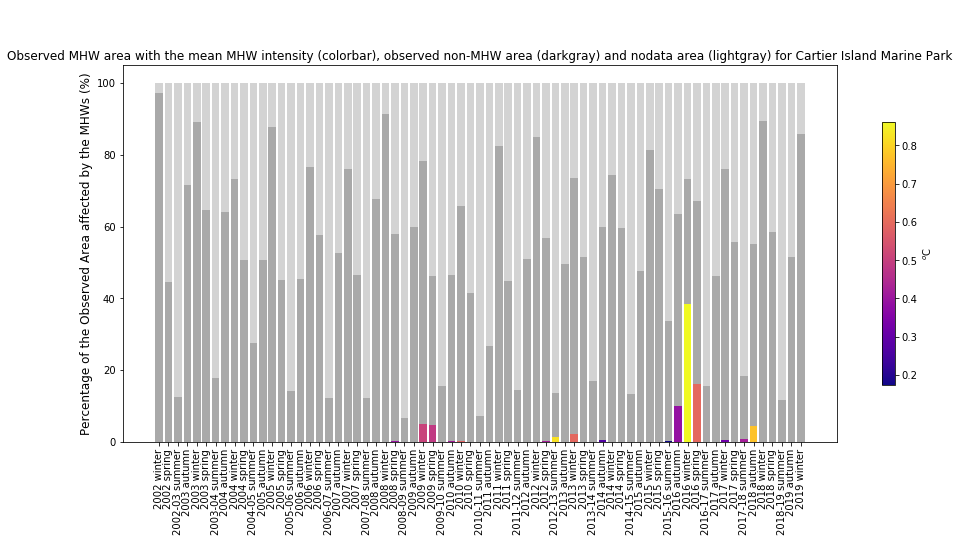

In [44]:

fig = plt.figure(figsize=(16,8))
cmap = matplotlib.cm.get_cmap('plasma')
# two rows, 1 column, first row is 1/20 of the second row in height
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 20])
# set up data
x = season_data['season'].values
mhwPixels = season_data['count'].values
observedPixels = season_data['observed2'].values
# calculate total number of pixels within the entire marine park for the whole season
totalPixels = MODIS_data_cleaned.sst_interp.mean(dim='time').count().values * season_data['noDays'].values
nonMHWPixels = observedPixels - mhwPixels
nodataPixels = totalPixels - observedPixels
y1 = mhwPixels / totalPixels * 100
y2 = nonMHWPixels / totalPixels * 100
y3 = nodataPixels / totalPixels * 100
z1 = season_data['mean'].values # display as colormap according to its values
mhwDays = season_data['mhwDays'].values
z1_min = np.nanmin(z1)
z1_max = np.nanmax(z1)

z2 = (z1 - z1_min) / (z1_max - z1_min) # normalise the data to [0,1], to match the range of the colormap

ax0 = plt.subplot(gs[0]) # the upper row
ax1 = plt.subplot(gs[1]) # the lower row

# plot bar one by one with the color matching the value of Z data
i = 0
while i < x.size:     
    ax1.bar(x[i], y1[i], facecolor=cmap(z2[i]), alpha=1)
    ax1.bar(x[i], y2[i], bottom=y1[i], facecolor="darkgray", alpha=1)
    ax1.bar(x[i], y3[i], bottom=y1[i]+y2[i], facecolor="lightgray", alpha=1)
    
    i += 1

ax1.set_ylabel("Percentage of the Observed Area affected by the MHWs (%)",fontsize=12)
ax1.set_title('Observed MHW area with the mean MHW intensity (colorbar), observed non-MHW area (darkgray) and nodata area (lightgray) for ' + AMP_name + ' Marine Park')
# rotate the x labels, lower row
for tick in ax1.get_xticklabels():
    tick.set_rotation(90)
    
# create a dummy image (upper row) using the chosen colormap, so that the colormap can be shown as colorbar for the lower row  
# the purpose is not to show the image by setting the extent with vertical coordinates of '0,0',
# and later turning the axis off; but importantly, needs to set vmin and vmax so that the colorbar display 
# correct max and min values
colors = cmap(np.arange(cmap.N))
ima = ax0.imshow([colors],cmap=cmap,vmin=z1_min,vmax=z1_max,extent=([z1_min,z1_max,0,0]))
ax0.set_axis_off()
# plot the colorbar on the lower row
cbar = plt.colorbar(ima,ax=ax1,shrink=0.7)
cbar.set_label('$^o$C')
plt.show()

Plot a figure using the seasonal statistics. The height of the y-axis shows the number of days that have been identified as MHW, non-MHW and nodata for each season. The colors indicates other statistics, for example the mean MHW intensity in this case

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:44: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.


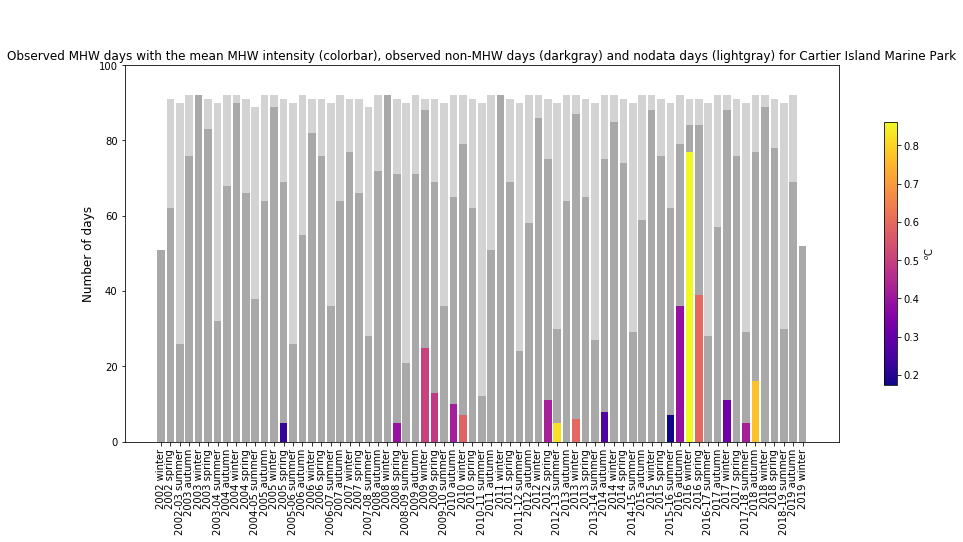

In [45]:

fig = plt.figure(figsize=(16,8))
cmap = matplotlib.cm.get_cmap('plasma')
# two rows, 1 column, first row is 1/20 of the second row in height
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 20])
# set up data
x = season_data['season']
mhwDays = season_data['mhwDays'].values
nodataDays = season_data['nodataDays'].values
totalDays = season_data['noDays'].values
nonMHWDays = totalDays - nodataDays - mhwDays

z1 = season_data['mean'].values # display as colormap according to its values
mhwDays = season_data['mhwDays'].values
z1_min = np.nanmin(z1)
z1_max = np.nanmax(z1)

z2 = (z1 - z1_min) / (z1_max - z1_min) # normalise the data to [0,1], to match the range of the colormap

ax0 = plt.subplot(gs[0]) # the upper row
ax1 = plt.subplot(gs[1]) # the lower row

# plot bar one by one with the color matching the value of Z data
i = 0
while i < x.size:     
    ax1.bar(x[i], mhwDays[i], facecolor=cmap(z2[i]), alpha=1)
    ax1.bar(x[i], nonMHWDays[i], bottom=mhwDays[i], facecolor="darkgray", alpha=1)
    ax1.bar(x[i], nodataDays[i], bottom=mhwDays[i]+nonMHWDays[i], facecolor="lightgray", alpha=1)
    
    i += 1


ax1.set_ylabel("Number of days",fontsize=12)
ax1.set_title('Observed MHW days with the mean MHW intensity (colorbar), observed non-MHW days (darkgray) and nodata days (lightgray) for '
              + AMP_name + ' Marine Park')
# rotate the x labels, lower row
for tick in ax1.get_xticklabels():
    tick.set_rotation(90)
ax1.set_ylim(0,100)    
# create a dummy image (upper row) using the chosen colormap, so that the colormap can be shown as colorbar for the lower row  
# the purpose is not to show the image by setting the extent with vertical coordinates of '0,0',
# and later turning the axis off; but importantly, needs to set vmin and vmax so that the colorbar display 
# correct max and min values
colors = cmap(np.arange(cmap.N))
ima = ax0.imshow([colors],cmap=cmap,vmin=z1_min,vmax=z1_max,extent=([z1_min,z1_max,0,0]))
ax0.set_axis_off()
# plot the colorbar on the lower row
cbar = plt.colorbar(ima,ax=ax1,shrink=0.7)
cbar.set_label('$^o$C')
plt.show()

Plot a figure using the seasonal statistics. The left y-axis shows the percentage of marine park that have been 
affected by MHWs at some points of time within the season. The right y-axis shows the number of MHW days. The colors indicates other statistics, for example the mean MHW intensity in this case

[-10.   0.  10.  20.  30.  40.  50.  60.  70.  80.  90.]


/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:45: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.


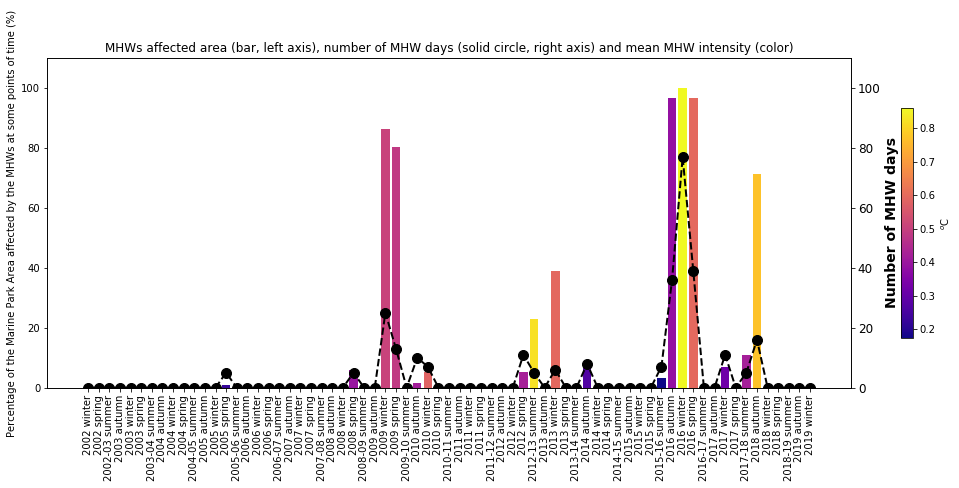

In [46]:

fig = plt.figure(figsize=(18,7))
cmap = matplotlib.cm.get_cmap('plasma')
# two rows, 1 column, first row is 1/20 of the second row in height
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 20])
# set up data
x = season_data['season']
totalPixels = MODIS_data_cleaned.sst_interp.mean(dim='time').count().values
y = season_data['mhwPixels'].values / totalPixels * 100
z1 = season_data['mean'].values # display as colormap according to its values
mhwDays = season_data['mhwDays'].values
z1_min = np.nanmin(z1)
z1_max = np.nanmax(z1)

z2 = (z1 - z1_min) / (z1_max - z1_min) # normalise the data to [0,1], to match the range of the colormap

ax0 = plt.subplot(gs[0]) # the upper row
ax1 = plt.subplot(gs[1]) # the lower row

# plot bar one by one with the color matching the value of Z data
i = 0
while i < x.size:     
    ax1.bar(x[i], y[i], facecolor=cmap(z2[i]), alpha=1)
    i += 1

ax2 = ax1.twinx()
ax2.plot(x, mhwDays, color='black', linestyle='dashed', marker='o', linewidth=2, markersize=10)
ax2.set_ylabel('Number of MHW days', fontsize=14, fontweight='bold')
ax2.tick_params(colors='black',labelsize=12)
loc = ax2.get_yticks()
print(loc)
ax2.set_ylim(0,110)

ax1.set_ylabel("Percentage of the Marine Park Area affected by the MHWs at some points of time (%)",fontsize=10)
ax1.set_title('MHWs affected area (bar, left axis), number of MHW days (solid circle, right axis) and mean MHW intensity (color)')
ax1.set_ylim(0,110)
# rotate the x labels, lower row
for tick in ax1.get_xticklabels():
    tick.set_rotation(90)
    
# create a dummy image (upper row) using the chosen colormap, so that the colormap can be shown as colorbar for the lower row  
# the purpose is not to show the image by setting the extent with vertical coordinates of '0,0',
# and later turning the axis off; but importantly, needs to set vmin and vmax so that the colorbar display 
# correct max and min values
colors = cmap(np.arange(cmap.N))
ima = ax0.imshow([colors],cmap=cmap,vmin=z1_min,vmax=z1_max,extent=([z1_min,z1_max,0,0]))
ax0.set_axis_off()
# plot the colorbar on the lower row
cbar = plt.colorbar(ima,ax=ax1,shrink=0.7)
cbar.set_label('$^o$C')
plt.show()

plot a figure showing the percentages of the marine park area affected by different MHW categories at some points of time within the season

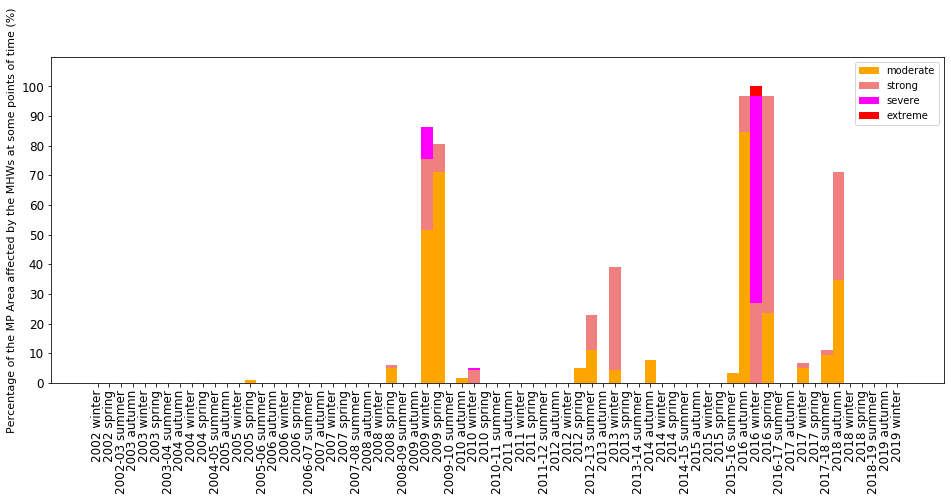

In [47]:

fig = plt.figure(figsize=(16,6))
# set up data
seasons = season_data['season']
moCount = season_data['moPixels'].values
stCount = season_data['stPixels'].values
seCount = season_data['sePixels'].values
exCount = season_data['exPixels'].values
totalPixels = MODIS_data_cleaned.sst_interp.mean(dim='time').count().values

moP = moCount / totalPixels * 100
moP = np.nan_to_num(moP)
stP = stCount / totalPixels * 100
stP = np.nan_to_num(stP)
seP = seCount / totalPixels * 100
seP = np.nan_to_num(seP)
exP = exCount / totalPixels * 100
exP = np.nan_to_num(exP)
width = 1.0
plt.ylim([0,110])
p1 = plt.bar(seasons,moP,width,color='orange')
p2 = plt.bar(seasons,stP,width,bottom=moP,color='lightcoral')
p3 = plt.bar(seasons,seP,width,bottom=moP+stP,color='magenta')
p4 = plt.bar(seasons,exP,width,bottom=moP+stP+seP,color='red')
plt.yticks(np.arange(0,110,10))
plt.legend((p1[0],p2[0],p3[0],p4[0]),('moderate','strong','severe','extreme'))
plt.ylabel("Percentage of the MP Area affected by the MHWs at some points of time (%)",fontsize=11)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12,rotation=90)
plt.show()


plot a figure showing the numbers of MHW days with different categories, non-MHW days and nodata days

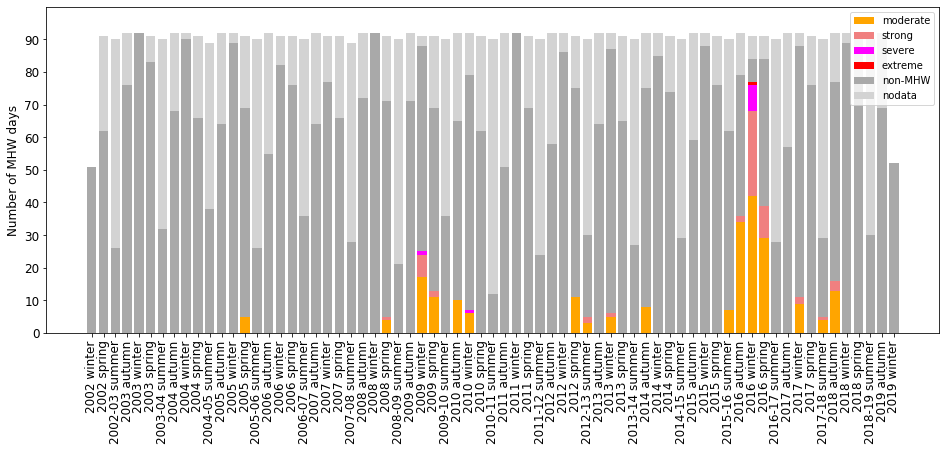

In [48]:
fig = plt.figure(figsize=(16,6))
# set up data
seasons = season_data['season']
moDays = season_data['moDays'].values
stDays = season_data['stDays'].values
seDays = season_data['seDays'].values
exDays = season_data['exDays'].values
nodataDays = season_data['nodataDays'].values
totalDays = season_data['noDays'].values
nonMHWDays = totalDays - nodataDays - exDays - seDays - stDays - moDays

width = 0.8
plt.ylim([0,100])
p1 = plt.bar(seasons,moDays,width,color='orange')
p2 = plt.bar(seasons,stDays,width,bottom=moDays,color='lightcoral')
p3 = plt.bar(seasons,seDays,width,bottom=moDays+stDays,color='magenta')
p4 = plt.bar(seasons,exDays,width,bottom=moDays+stDays+seDays,color='red')
p5 = plt.bar(seasons,nonMHWDays,width,bottom=moDays+stDays+seDays+exDays,color='darkgray')
p6 = plt.bar(seasons,nodataDays,width,bottom=moDays+stDays+seDays+exDays+nonMHWDays,color='lightgray')
plt.yticks(np.arange(0,100,10))
plt.legend((p1[0],p2[0],p3[0],p4[0],p5[0],p6[0]),('moderate','strong','severe','extreme','non-MHW','nodata'))
plt.ylabel("Number of MHW days",fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12,rotation=90)
plt.show()


plot a figure showing the daily variation of the percentages of marine park area affected by MHW, non-MHW and nodata

select the season with the highest number of MHW days as an example

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.


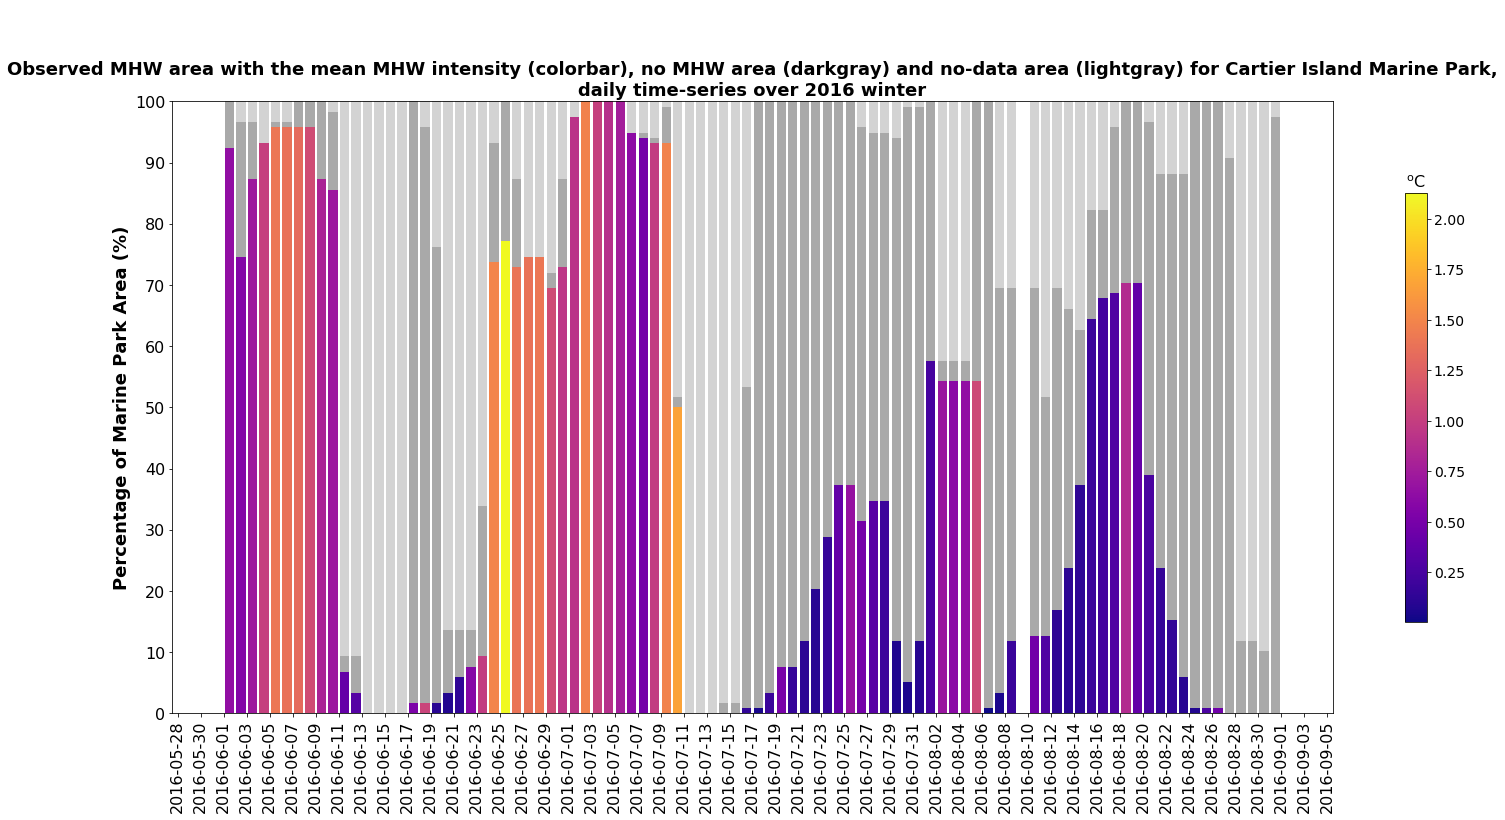

In [49]:
fig = plt.figure(figsize=(26,13))
cmap = matplotlib.cm.get_cmap('plasma')
# two rows, 1 column, first row is 1/20 of the second row in height
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 20])
# set up data
# select the season with the highest number of mhw days
x = season_data['mhwDays'].max()
seasonIndex = season_data['season'][season_data['mhwDays'] >= x].values[0]
year = seasonIndex.split(' ')[0]
season = seasonIndex.split(' ')[1]
if season == 'winter':
    date1 = year + '0601'
    date2 = year + '0831'
if season == 'spring':
    date1 = year + '0901'
    date2 = year + '1130'
if season == 'summer':
    date1 = year + '1201'
    date2 = str(int(year)+1) + '0228'
if season == 'autumn':
    date1 = year + '0301'
    date2 = year + '0531'
   
seasonYear = MODIS_data_statistics.sel(time=slice(date1,date2))
x = seasonYear.time.values
totalPixels = MODIS_data_cleaned.sst_interp.mean(dim='time').count().values
mhwPixels = seasonYear['MHW_count'].values
noMHWPixels = seasonYear['Observed_count'].values - seasonYear['MHW_count'].values
nodataPixels = totalPixels - seasonYear['Observed_count'].values

mhwP = mhwPixels / totalPixels * 100
noMHWP = noMHWPixels / totalPixels * 100
nodataP = nodataPixels / totalPixels * 100
z1 = seasonYear['mean_intensity'].values # display as colormap according to its values
z1_min = np.nanmin(z1)
z1_max = np.nanmax(z1)

z2 = (z1 - z1_min) / (z1_max - z1_min) # normalise the data to [0,1], to match the range of the colormap

ax0 = plt.subplot(gs[0]) # the upper row
ax1 = plt.subplot(gs[1]) # the lower row

# plot bar one by one with the color matching the value of Z data
i = 0
while i < x.size:     
    ax1.bar(x[i], mhwP[i], facecolor=cmap(z2[i]), alpha=1)
    ax1.bar(x[i], noMHWP[i], bottom=mhwP[i],facecolor="darkgray", alpha=1)
    ax1.bar(x[i], nodataP[i], bottom=mhwP[i]+noMHWP[i],facecolor="lightgray", alpha=1)
    i += 1

ax1.set_ylabel('Percentage of Marine Park Area (%)',fontsize=18,fontweight='bold')
ax1.set_title('Observed MHW area with the mean MHW intensity (colorbar), no MHW area (darkgray) and no-data area (lightgray) for ' + AMP_name + ' Marine Park,' + '\n' + 'daily time-series over ' + seasonIndex, fontsize=18, fontweight='bold')
ax1.set_yticks(np.arange(0,110,10))
ax1.set_yticklabels(np.arange(0,110,10),fontsize=16)
loc = ticker.MultipleLocator(base=2.0) # this locator puts ticks at regular intervals
ax1.xaxis.set_major_locator(loc)
# rotate the x labels, lower row
for tick in ax1.get_xticklabels():
    tick.set_rotation(90)
    tick.set_fontsize(16)

# create a dummy image (upper row) using the chosen colormap, so that the colormap can be shown as colorbar for the lower row  
# the purpose is not to show the image by setting the extent with vertical coordinates of '0,0',
# and later turning the axis off; but importantly, needs to set vmin and vmax so that the colorbar display 
# correct max and min values
colors = cmap(np.arange(cmap.N))
ima = ax0.imshow([colors],cmap=cmap,vmin=z1_min,vmax=z1_max,extent=([z1_min,z1_max,0,0]))
ax0.set_axis_off()
# plot the colorbar on the lower row
cbar = plt.colorbar(ima,ax=ax1,shrink=0.7)
cbar.ax.set_title('$\mathregular{^oC}$', fontsize=16, rotation=0)
cbar.ax.tick_params(labelsize=14)
plt.show()

plot a figure showing the daily variation of the percentages of marine park area affected by different MHW categories, non-MHW and nodata

select the season with the highest number of MHW days as an example

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


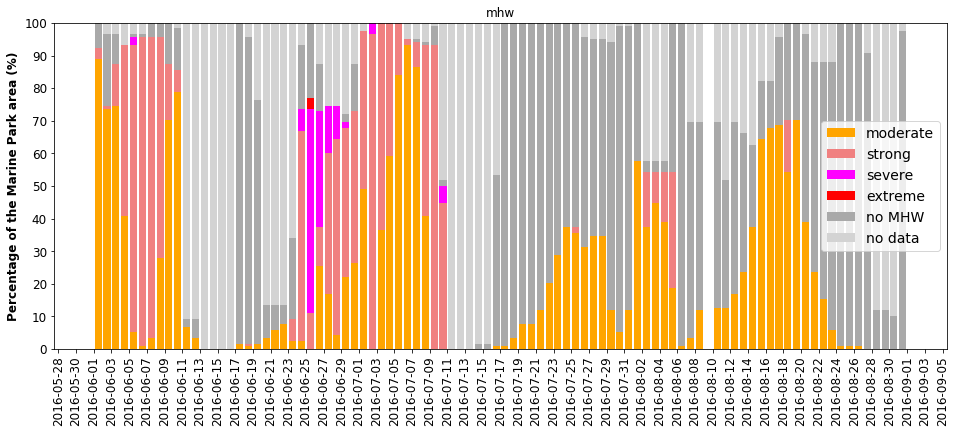

In [50]:
fig = plt.figure(figsize=(16,6))
# set up data
# select the season with the highest number of mhw days
x = season_data['mhwDays'].max()
seasonIndex = season_data['season'][season_data['mhwDays'] >= x].values[0]
year = seasonIndex.split(' ')[0]
season = seasonIndex.split(' ')[1]
if season == 'winter':
    date1 = year + '0601'
    date2 = year + '0831'
if season == 'spring':
    date1 = year + '0901'
    date2 = year + '1130'
if season == 'summer':
    date1 = year + '1201'
    date2 = str(int(year)+1) + '0228'
if season == 'autumn':
    date1 = year + '0301'
    date2 = year + '0531'

seasonYear = MODIS_data_statistics.sel(time=slice(date1,date2))
days = seasonYear.time.values

totalPixels = MODIS_data_cleaned.sst_interp.mean(dim='time').count().values
noMHWPixels = seasonYear['Observed_count'].values - seasonYear['MHW_count'].values
nodataPixels = totalPixels - seasonYear['Observed_count'].values

moCount = seasonYear['Moderate_count'].values
stCount = seasonYear['Strong_count'].values
seCount = seasonYear['Severe_count'].values
exCount = seasonYear['Extreme_count'].values

moP = moCount / totalPixels * 100
stP = stCount / totalPixels * 100
seP = seCount / totalPixels * 100
exP = exCount / totalPixels * 100

noMHWP = noMHWPixels / totalPixels * 100
nodataP = nodataPixels / totalPixels * 100

width = 0.8
plt.ylim([0,100])
p1 = plt.bar(days,moP,width,color='orange')
p2 = plt.bar(days,stP,width,bottom=moP,color='lightcoral')
p3 = plt.bar(days,seP,width,bottom=moP+stP,color='magenta')
p4 = plt.bar(days,exP,width,bottom=moP+stP+seP,color='red')
p5 = plt.bar(days,noMHWP,width,bottom=moP+stP+seP+exP,color='darkgray')
p6 = plt.bar(days,nodataP,width,bottom=moP+stP+seP+exP+noMHWP,color='lightgray')
plt.yticks(np.arange(0,110,10))
plt.legend((p1[0],p2[0],p3[0],p4[0],p5[0],p6[0]),('moderate','strong','severe','extreme','no MHW','no data'),fontsize=14)
plt.ylabel("Percentage of the Marine Park area (%)",fontsize=12,fontweight='bold')
plt.title("mhw")
loc = ticker.MultipleLocator(base=2.0) # this locator puts ticks at regular intervals
ax = plt.axes()
ax.xaxis.set_major_locator(loc)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12,rotation=90)
plt.show()

#### plot the summary statistics as maps

use total MHW intensity and number of severe MHW days as examples

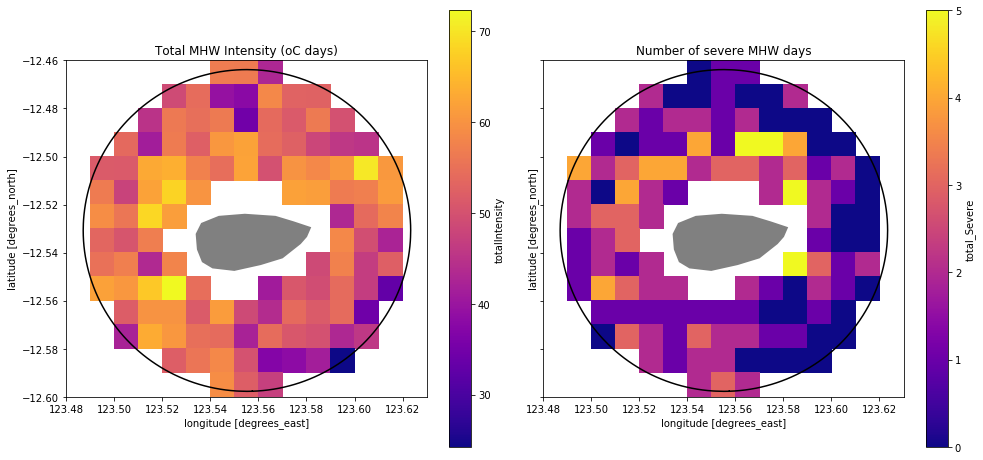

In [51]:
AMP = shpf.Reader(AMP_shp)
width = 14
height = round(width * h_w_ratio)
f, (ax1,ax2) = plt.subplots(1,2,sharey='all',figsize=(width,height/2))

#totalIntensity
if os.path.exists(reefs_islands_shp):    
    shape_plot = gpd.read_file(reefs_islands_shp)
    shape_plot.plot(color='gray',ax=ax1)

MODIS_data_cleaned.totalIntensity.plot(cmap='plasma',ax=ax1)
ax1.set_title('Total MHW Intensity (oC days)')
for shape in AMP.shapeRecords():
    
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    ax1.plot(x, y, 'k')
#number of severe MHW days
if os.path.exists(reefs_islands_shp):    
    shape_plot = gpd.read_file(reefs_islands_shp)
    shape_plot.plot(color='gray',ax=ax2)
MODIS_data_cleaned.total_Severe.plot(cmap='plasma',ax=ax2)
for shape in AMP.shapeRecords():
    
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    ax2.plot(x, y, 'k')

ax2.set_title('Number of severe MHW days')
f.tight_layout() 
plt.show()

ax2.set_title('Number of severe MHW days')
f.tight_layout() 
plt.show()

#### plot daily MHW maps

use the MHW intensity and the MHW categories of a day with the maximum number of MHW pixels as examples

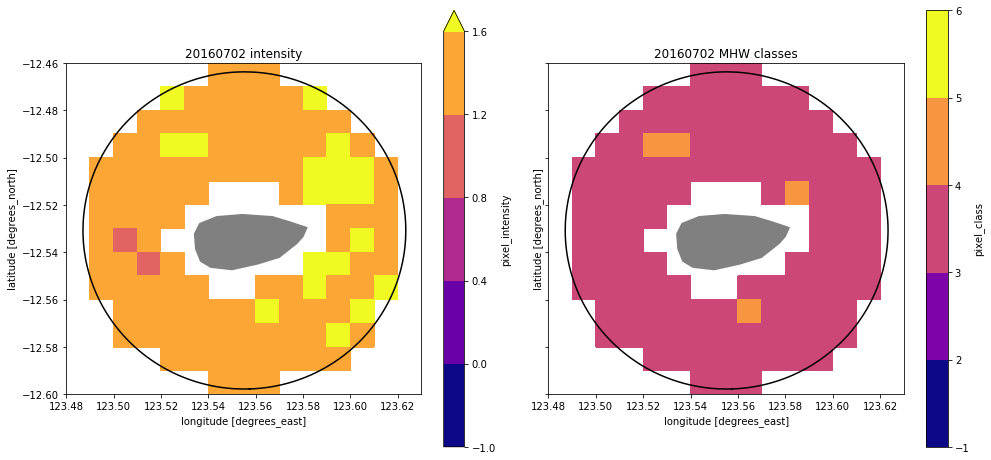

In [52]:
AMP = shpf.Reader(AMP_shp)
width = 14
height = round(width * h_w_ratio)
f, (ax1,ax2) = plt.subplots(1,2,sharey='all',figsize=(width,height/2))
# select the data with maximum number of MHW pixels
tempDF = MODIS_data_statistics['MHW_count'][MODIS_data_statistics.MHW_count >= MODIS_data_statistics.MHW_count.max()].time
date = tempDF.dt.strftime('%Y%m%d').values[0]
# try to use discrete colormap to display the maps
# note that nodata pixels (value = -1) are also shown
#MHW intensity
maxV = MODIS_data_statistics.sel(time=slice(date,date))['max_intensity'].values
levels = np.arange(0,maxV,0.4) # class interval value is set at 0.4
levels = np.insert(levels,0,-1) # value -1 (nodata) is used as anthor discrete level
MODIS_data_statistics.sel(time=slice(date,date))['pixel_intensity'].plot(levels=levels,cbar_kwargs={"ticks": levels},cmap='plasma',ax=ax1)
if os.path.exists(reefs_islands_shp):        
    shape_plot = gpd.read_file(reefs_islands_shp)
    shape_plot.plot(color='gray',ax=ax1)
for shape in AMP.shapeRecords():
    
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    ax1.plot(x, y, 'k')

ax1.set_title(date + ' intensity')

#MHW categories
if os.path.exists(reefs_islands_shp):        
    shape_plot = gpd.read_file(reefs_islands_shp)
    shape_plot.plot(color='gray',ax=ax2)
# 2-3 -> moderate MHW category; 3-4 -> strong MHW category; 4-5 -> severe MHW category; 5-6 -> extreme MHW category
# -1 -> nodata
MODIS_data_statistics.sel(time=slice(date,date))['pixel_class'].plot(levels=[-1,2,3,4,5,6],cmap='plasma',ax=ax2)
for shape in AMP.shapeRecords():
    
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    ax2.plot(x, y, 'k')

ax2.set_title(date + ' MHW classes')
f.tight_layout()
plt.show()


<a id='References'></a>
## References
Hobday, A.J., Alexander, L.V., Perkins, S.E., Smale, D.A., Straub, S.C., Oliver, E.C.J., Benthuysen, J., Burrows, M.T., Donat, M.G., Feng, M., Holbrook, N.J., Moore, P.J., Scannell, H.A., Gupta, A.S., & Wernberg, T. (2016). A hierarchical approach to defining marine heatwaves. Progress In Oceanography, 141, 227-238

Hobday, A.J., Oliver, E.C.J., Sen Gupta, A., Benthuysen, J., Burrows, M.T., Donat, M.G., Holbrook, N.J., Moore, P.J., Thomsen, M.S., Wernberg, T., & Smale, D.A. (2018). Categorizing and naming marine heatwaves. Oceanography, 31, 162-173

## Additional information
    
**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0).
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.
  
**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).
 
**Last modified:** June 2020
   
**Compatible datacube version:** 

In [53]:
print(datacube.__version__)

1.7+142.g7f8581cf


## Tags

Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)